Program to identify suspicious values in Prim master file by comparing it with RTWS daily PRIM files

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
plt.style.use('fivethirtyeight')

from datetime import datetime, time, timedelta
from numpy import array, polyfit, poly1d
from pandas import DataFrame, to_datetime
from pandas.plotting import register_matplotlib_converters
from tkinter import *
from tkinter import filedialog

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import os, sys
import pylab
import scipy as sp
import scipy.stats

%matplotlib inline

In [2]:
def get_master_file(master_file_type):

# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = "C:\QGHL\Wave_data\Masters", 
                        title = "Select "+master_file_type+" Master file",\
                        filetypes = (("Prim files","*.prim"),("Seco files","*.seco"),("Dseco files","*.dseco.corrected"),("all files","*.*")))
    root.destroy()

    return(root.filename)    # get_master_file

In [3]:
def get_RTWS_Prim_file():

# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = 'C:\QGHL\Wave_data', title = 'Select RTWS PRIM file',\
                        filetypes = (('all files','*.*'),('Prim files','*.prim'),('Seco files','*.seco')))
    root.destroy()
    
    print(root.filename)

    return(root.filename)    # get_RTWS_Prim_file()

In [4]:
def get_RTWS_Seco_file():

# Select input file
    root = Tk()
    root.filename =  filedialog.askopenfilename(initialdir = 'C:\QGHL\Wave_data', title = 'Select RTWS SECO file',\
                        filetypes = (('all files','*.*'),('Seco files','*.seco'),('Prim files','*.seco')))
    root.destroy()
    
    print(root.filename)

    return(root.filename)    # get_RTWS_Seco_file()

In [5]:
def Date_range(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)
    return()    # Date_range()

In [6]:
def remove_zeros(recs,Input_File):

# Locate, and remove errant zero's from data
    zero_data = recs.loc[recs.date_val.apply(lambda x: x[0])==0].index
    if len(zero_data) > 0:
        recs_zero = recs    # make a copy to locate where the zeros occur
        date_string =  [[recs.loc[zero_data[0]-1].date_val.tolist()][0][i] for i in range(0,10,2)]
        ' '.join(str(p) for p in [date_string])
        first_val = str(date_string[0])+'/'+str(date_string[1])+'/'+str(date_string[2])+' '+str(date_string[3]) \
            +':'+str(date_string[4])
        date_string =  [[recs.loc[zero_data[-1]+1].date_val.tolist()][0][i] for i in range(0,10,2)]
        ' '.join(str(p) for p in [date_string])
        last_val = str(date_string[0])+'/'+str(date_string[1])+'/'+str(date_string[2])+' '+str(date_string[3]) \
            +':'+str(date_string[4])
        print('Alert: ',len(zero_data),' Zero\'s found (and removed) between ',first_val,' and ',last_val)
    else:
        print('No zeros found in ',Input_File)

    recs = recs.loc[recs.date_val.apply(lambda x: x[0])!=0]

    return(recs)    # remove_zeros()

In [7]:
def convert_dates(recs):
# Convert date/time column data into Dates and times
    Record_time = pd.DataFrame(recs.date_val.values.tolist(), \
            columns=['year','j1','month','j2','day','j3','hour','j4','minute','j5','second','j6'])

    Record_time['year'] = Record_time['year'].mask(Record_time['year'] < 1900, Record_time['year'] + 1900)

    # Insert Date column at start of DF
    recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')

    return(recs)    # convert_dates()

In [8]:
def get_RTWS_SECO_data(recs):
    
    Start_File = get_RTWS_Seco_file()
    date_str = Start_File.split('/')[-1].split('.')[0]
    Start_time = datetime.strptime(date_str[3:], "%d%m%Y")

    # Get name of input SECO file
    site = Start_File.split('/')[-1].split('}')[0].upper()

    ##End_File = get_file()
    ##date_str = End_File.split('/')[-1].split('.')[0]
    ##End_time = datetime.strptime(date_str[3:], "%d%m%Y")
    End_time = Start_time + timedelta(days=365)
    
    Path = os.path.dirname(Start_File)
    File_name = os.path.basename(Start_File)

    Front_part = Start_File.split('/')[0]
    Extension = Start_File.split('.')[-1]

    Days = (End_time-Start_time).days

    recs = pd.DataFrame([])

    aa = []

    for dt in Date_range(Start_time, End_time):
        Input_File = Path+'/'+date_str[0:3]+dt.strftime("%d%m%Y")+'.'+Extension

        error_to_catch = getattr(__builtins__,'FileNotFoundError', IOError)

        try:
    # Read data from the RTWS SECO file
##            print('Reading data from RTWS SECO file:',Input_File)
            # Open file
            f = open(Input_File)

    # Read data from the Binary file into a DF based on the structure in the DT
            data = np.fromfile(f, rectype_RTWS_seco)
            aa.append(DataFrame.from_records(np.array(data).tolist()))

        except error_to_catch:
            print('WARNING... ',Input_File,' NOT Found!')

    recs = pd.concat(aa)
    # Assign column names to DF
    recs.columns = ['Date_val','Buoy','Verstr','m0','m1','m2','m4','Tp','board','Elapse','Hm0',
                    'Pktdir','Avedir','Pkdir','Pdens','Jdir','Jpower','Jspread','Pad']

    # remove those records with zero dates
    recs = recs.loc[recs.Date_val.apply(pd.Series)[0]>0]

    # Convert date/time column data into Dates and times
    Record_time = pd.DataFrame(recs.Date_val.values.tolist(), \
            columns=['year','month','day','hour','minute','second'])

    ##Record_time['year'] = Record_time['year'].mask(Record_time['year'] < 1900, Record_time['year'] + 1900)

    # Insert Date column at start of DF
    recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')

    return(recs)    # get_RTWS_SECO_data()

In [9]:
def get_RTWS_PRIM_data(recs):
    
    Start_File = get_RTWS_Prim_file()
    date_str = Start_File.split('/')[-1].split('.')[0]
    Start_time = datetime.strptime(date_str[3:], "%d%m%Y")

    # Get name of input PRIM file
    site = Start_File.split('/')[-1].split('}')[0].upper()

    ##End_File = get_file()
    ##date_str = End_File.split('/')[-1].split('.')[0]
    ##End_time = datetime.strptime(date_str[3:], "%d%m%Y")
    End_time = Start_time + timedelta(days=365)

    Path = os.path.dirname(Start_File)
    File_name = os.path.basename(Start_File)

    Front_part = Start_File.split('/')[0]
    Extension = Start_File.split('.')[-1]

    Days = (End_time-Start_time).days

    aa = []

    for dt in Date_range(Start_time, End_time):
        Input_File = Path+'/'+date_str[0:3]+dt.strftime("%d%m%Y")+'.'+Extension

        error_to_catch = getattr(__builtins__,'FileNotFoundError', IOError)

        try:
    # Read data from the HVA file
##            print('Reading data from RTWS Prim file:',Input_File)
            # Open file
            f = open(Input_File)

            # Read data from the Binary file into a DF based on the structure in the DT
            data = np.fromfile(f, rectype_RTWS_prim)
            aa.append(DataFrame.from_records(np.array(data).tolist()))

        except error_to_catch:
            print('WARNING... ',Input_File,' NOT Found!')

    recs = pd.concat(aa)
    # Assign column names to DF
    recs.columns = ['Date_val','Buoy','Verstr','Hsig','Hm','Hmax','Tz','Thsig','Tc','Thmax','Eps','T02',
                    'Tp','Hrms','Epss','Noise','Nspike','Nroc','Errors','Spikemax','Rocmax',
                    'Samax','Sigma','Burlen','Deltat','Nwaves','Tzmax','E04','E60','Ierr','Start',
                    'Burint','H10','Th10','Elapse','Hm0','Dtz','Pdens','Rtemp','Wtemp','Status',
                    'Vacc','Xacc','Yacc','Orient','Inclin','Pktdir','Avedir','Pkdir','Pad']

    #Seek out and remove records containing zeros
    len_1 = len(recs)
    recs = recs.loc[recs.Status != 0]
    print('ALERT: '+str(len_1 - len(recs))+' Records containing only zeros have been removed from the data!')

    # Convert date/time column data into Dates and times
    Record_time = pd.DataFrame(recs.Date_val.values.tolist(), \
            columns=['year','month','day','hour','minute','second'])

    Record_time['year'] = Record_time['year'].mask(Record_time['year'] < 1900, Record_time['year'] + 1900)

    # Insert Date column at start of DF
    recs.index = pd.to_datetime(Record_time[['year','month','day','hour','minute','second']],format='%Y:%m:%d:%H:%M:%S')
    
    return(recs)    # get_RTWS_PRIM_data()


In [10]:
def get_PRIM_Master_data(recs_prim):
    ############################################################################################
    # Get name of input PRIM Master file
    Input_Prim_File = get_master_file("PRIM")
    site = Input_Prim_File.split('/')[-1].split('}')[0].upper()

    # Open file
    f = open(Input_Prim_File)

    # Read data from the Binary file into a DF based on the structure in the DT
    data = np.fromfile(f, rectype_master_prim)
    recs_prim = DataFrame.from_records(np.array(data).tolist())

    # Assign column names to DF
    recs_prim.columns = ['Procid','Loc','date_val','Hsig','Thsig','Hrms','Hmax','Tc','Tz','H10','Th10',
                         'Thmax','Tzmax','Hm0','T02','Tp','EPS','Npts','Param2']

    # Locate, and remove errant zero's from data
    recs_prim = remove_zeros(recs_prim,Input_Prim_File)

    # Convert date/time column data into Dates and times
    recs_prim = convert_dates(recs_prim)

    # Remove unwanted columns from Prim DF
    recs_prim = recs_prim.drop(columns=[
        'Procid',
        'Loc',
        'date_val',
        'Param2'], axis=1)
 
    return(recs_prim,Input_Prim_File)    # get_PRIM_Master_data()

In [11]:
def get_DSECO_Master_data(recs_dseco):
    ############################################################################################
    # Get name of input PRIM Master file
    Input_Dseco_File = get_master_file("DSECO")
##    site = Input_Dseco_File.split('/')[-1].split('}')[0].upper()

    # Open file
    f = open(Input_Dseco_File)

    # Read data from the Binary file into a DF based on the structure in the DT
    data = np.fromfile(f, rectype_master_dseco)
    recs_dseco = DataFrame.from_records(np.array(data).tolist())

    # Assign column names to DF
    recs_dseco.columns = ['Procid','Loc','date_val','Elapse','Hm0','T02','Pdens','SST',
                          'Vacc','Xacc','Yacc','Orient','Inclin','TP_Buoy',
                          'Avg_Dir','Peak_Dir','Corr_to_True','jdirn','jrpower','jspread']

    # Locate, and remove errant zero's from data
    recs_dseco = remove_zeros(recs_dseco,Input_Dseco_File)

    # Convert date/time column data into Dates and times
    recs_dseco = convert_dates(recs_dseco)

    # Remove unwanted columns from Dseco DF
    recs_dseco = recs_dseco.drop(columns=[
        'Procid',
        'Loc',
        'date_val',
        ], axis=1)
 
    return(recs_dseco)    # get_DSECO_Master_data()

In [12]:
############################################
#    MAIN PROGRAM
############################################

# Create a DT based on the structure type of the PRIM Master File
# Details copied from PV~Wave file Master_structure_types_corrected.pro
rectype_master_prim = np.dtype([
    ('Procid','B',(12,)),
    ('Loc','i'),
#    ('Year','i'),('Month','i'),('Day', 'i'),('Hour', 'i'),('Min', 'i'), ('Sec','i'), 
    ('date_val','i2',(12)),
    ('Hsig','f4'), ('Thsig','f4'), ('Hrms', 'f'), ('Hmax', 'f'),('Tc', 'f'),('Tz', 'f'), ('H10', 'f'), 
    ('Th10', 'f'), ('Thmax', 'f'), ('Tzmax', 'f'), ('Hm0', 'f4'),('T02', 'f'),('Tp', 'f'), ('EPS', 'f'), 
    ('Npts', 'i'),
    ('Param2','f',(4,))
    ])

# Create a DT based on the structure type of the SECO Master File
# Details copied from PV~Wave file Master_structure_types_corrected.pro

##rectype_master_seco = np.dtype([(
##    'Loc','i'),
##    ('date_val','i2',(12)),
##    ('Spc', 'f', (60,))
##    ])

# Create a DT based on the structure type of the DSECO Master File
# Details copied from PV~Wave file Master_structure_types_corrected.pro

rectype_master_dseco = np.dtype([
    ('Procid','B',(12,)),
    ('Loc','i'),
    ('date_val','i2',(12)),
    ('Elapse','i2',(2)),
##    ('Dparam','f',12),
    ('Hm0','f'),('T02','f'),('Pdens','f'),('SST','f'),('Vacc','f'),('Xacc','f'),('Yacc','f'),
    ('Orient','f'),('Inclin','f'),('TP_Buoy','f'),('Avg_Dir','f'),('Peak_Dir','f'),
    ('Corr_to_True','f'),
    ('jdirn', 'i2', (64)),
    ('jrpower', 'i2', (64)),
    ('jspread', 'i2', (64)),                     
    ])

# Parameters in Dparam are:
#     hm0,t02,pdens,temp,vacc,xacc,yacc,orient,inclin,tp_buoy,avg_dir,peak_dir. 

# Create a DT based on the structure type of the RTWS daily PRIM file
# Details copied from PV~Wave file Master_structure_types_corrected.pro

rectype_RTWS_prim = np.dtype([
#    ('Year','i2'),('Month','i2'),('Day', 'i2'),('Hour', 'i2'),('Min', 'i2'), ('Sec','i2'), 
    ('Date_val','i2',(6)), 
    ('Buoy','i2'),
#    ('verstr',pp1),
    ('verstr','B',(8,)),
    ('Hsig','f4'),('Hm','f4'), ('Hmax', 'f4'),('Tz', 'f4'),('Thsig','f4'),('Tc', 'f4'), 
    ('Thmax', 'f4'),('Eps', 'f4'),('T02', 'f4'),
    ('Tp', 'f4'),('Hrms', 'f4'),('Epss', 'f4'),
    ('Noise', 'i2'),('Nspike', 'i2'),('Nroc', 'i2'),
    ('Errors', 'f4'),('Spikemax', 'f4'),('Rocmax', 'f4'),
    ('Samax', 'i2'),('Sigma', 'f4'),('Burlen', 'i2'),('Deltat', 'f4'),('Nwaves', 'i2'),
    ('Tzmax', 'f4'),('E04', 'f4'),('E60', 'f4'),
    ('Ierr', 'i2'),('Start', 'i2'),('Burint', 'i2'),
    ('H10', 'f4'),('Th10', 'f4'),
    ('Elapse', 'i2'),
    ('Hm0', 'f4'),('Dtz', 'f4'),('Pdens', 'f4'),('Rtemp', 'f4'),('Wtemp', 'f4'),
    ('Status', 'i2'),
    ('Vacc', 'f4'),('Xacc', 'f4'),('Yacc', 'f4'),('Orient', 'f4'),('Inclin', 'f4'),
    ('Pktdir', 'f4'),('Avedir', 'f4'),('Pkdir', 'f4'),
    ('Pad', 'B',(72,))
    ])

# Create a DT based on the structure type of the RTWS daily SECO file
# Details copied from PV~Wave file Master_structure_types_corrected.pro

rectype_RTWS_seco = np.dtype([
#    ('Year','i2'),('Month','i2'),('Day', 'i2'),('Hour', 'i2'),('Min', 'i2'), ('Sec','i2'), 
    ('Date_val','i2',(6)), 
    ('Buoy','i2'),
    ('verstr','B',(8,)),
    ('m0','f4'),('m1','f4'), ('m2', 'f4'),('m4', 'f4'),('Tp','f4'),('board', 'f4', (128,)), 
    ('Elapse', 'i2'),('Hm0', 'f4'),('Pktdir', 'f4'),('Avedir', 'f4'),('Pkdir', 'f4'),('Pdens', 'f4'),
    ('Jdir', 'i2', (64,)),('Jpower', 'i2', (64,)),('Jspread', 'i2', (64,)),
    ('Pad', 'B', (64,))
    ])

Recs_Master_prim = pd.DataFrame([])
Recs_Master_prim,Input_Prim_File = get_PRIM_Master_data(Recs_Master_prim)

Recs_Master_dseco = pd.DataFrame([])
Recs_Master_dseco = get_DSECO_Master_data(Recs_Master_dseco)

recs_RTWS_prim = pd.DataFrame([])
recs_RTWS_prim = get_RTWS_PRIM_data(recs_RTWS_prim)

recs_RTWS_seco = pd.DataFrame([])
recs_RTWS_seco = get_RTWS_SECO_data(recs_RTWS_seco)


No zeros found in  C:/QGHL/Wave_data/Master_files/twee----28.prim
No zeros found in  C:/QGHL/Wave_data/Master_files/twee----28.dseco.corrected
C:/QGHL/Wave_data/RTWS/TWEED/Prim/prm01011999.d28
WARNING...  C:/QGHL/Wave_data/RTWS/TWEED/Prim/prm21121999.d28  NOT Found!
WARNING...  C:/QGHL/Wave_data/RTWS/TWEED/Prim/prm22121999.d28  NOT Found!
WARNING...  C:/QGHL/Wave_data/RTWS/TWEED/Prim/prm01012000.d28  NOT Found!
ALERT: 1 Records containing only zeros have been removed from the data!
C:/QGHL/Wave_data/RTWS/TWEED/Seco/sec01011999.d28
WARNING...  C:/QGHL/Wave_data/RTWS/TWEED/Seco/sec21121999.d28  NOT Found!
WARNING...  C:/QGHL/Wave_data/RTWS/TWEED/Seco/sec22121999.d28  NOT Found!
WARNING...  C:/QGHL/Wave_data/RTWS/TWEED/Seco/sec01012000.d28  NOT Found!


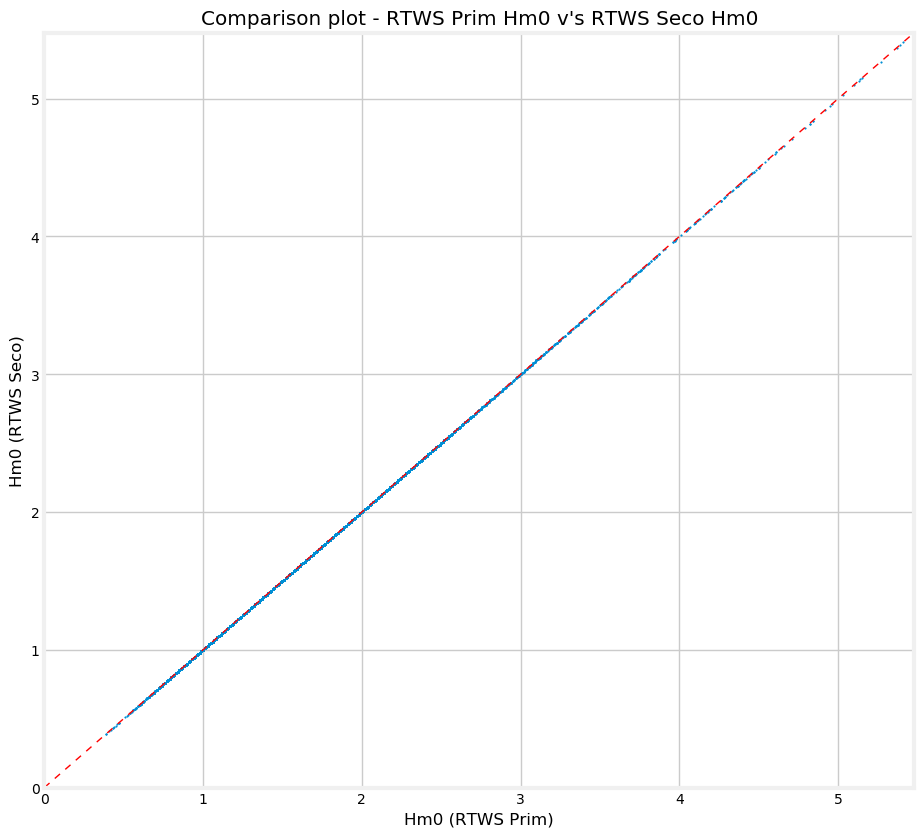

In [13]:
# Generate descriptive statistics of RTWS Prim Hm0/RTWS Seco Hm0 distribution
idx = recs_RTWS_prim.index.intersection(recs_RTWS_seco.index)
plt.rcParams['axes.facecolor'] = 'white'

plt.figure(figsize=(10,10),dpi=100)
#plt.plot(recs_RTWS_seco.index,4*np.sqrt(recs_RTWS_seco.m0))
#plt.plot(recs_RTWS_seco.index,recs_RTWS_seco.Hm0)
#plt.plot(recs_RTWS_prim.index,recs_RTWS_prim.Hm0)
plt.scatter(recs_RTWS_prim.loc[idx].Hm0,recs_RTWS_seco.loc[idx].Hm0,s=1)

plt.title("Comparison plot - RTWS Prim Hm0 v's RTWS Seco Hm0")
plt.xlabel("Hm0 (RTWS Prim)")
plt.ylabel("Hm0 (RTWS Seco)")
plt.xlim(left=0,right=max(recs_RTWS_prim.loc[idx].Hm0))
plt.ylim(bottom=0,top=max(recs_RTWS_seco.loc[idx].Hm0))

from numpy.polynomial import Polynomial

p = Polynomial.fit(recs_RTWS_prim.loc[idx].Hm0,recs_RTWS_seco.loc[idx].Hm0, 3)
plt.plot(*p.linspace(),lw=1.0,c="r",dashes=[5, 5, 5, 5])

In [ ]:
# Generate descriptive statistics of RTWS Prim Hm0/Master Prim Hm0 distribution
idx = recs_RTWS_prim.index.intersection(Recs_Master_prim.index)
idy = recs_RTWS_seco.index.intersection(Recs_Master_prim.index)
plt.rcParams['axes.facecolor'] = 'white'

plt.figure(figsize=(10,10),dpi=100)
plt.scatter(recs_RTWS_prim.loc[idx].Hm0,Recs_Master_prim.loc[idx].Hm0,s=3,c='b')
plt.scatter(recs_RTWS_seco.loc[idx].Hm0,Recs_Master_prim.loc[idx].Hm0,s=1,c='yellow')
plt.scatter(recs_RTWS_prim.loc[idx].Hrms*np.sqrt(2),Recs_Master_prim.loc[idx].Hm0,s=1,c='r')

plt.title("Comparison plot - RTWS Prim & Seco Hm0 v's Master Prim Hm0")
plt.xlabel("Hm0 (RTWS Prim and Seco)")
plt.ylabel("Hm0 (Master Prim)")
plt.xlim(left=0,right=max(recs_RTWS_prim.loc[idx].Hm0))
plt.ylim(bottom=0,top=max(Recs_Master_prim.loc[idx].Hm0))
plt.legend(["Prim", "Seco", "Hrms*np.sqrt(2)"],frameon=False)
from numpy.polynomial import Polynomial

p = Polynomial.fit(recs_RTWS_prim.loc[idx].Hm0,Recs_Master_prim.loc[idx].Hm0, 1)
plt.plot(*p.linspace(),lw=1.0,c="r",dashes=[5, 5, 5, 5])

In [ ]:
pd.options.display.max_columns = 100
recs_RTWS_prim

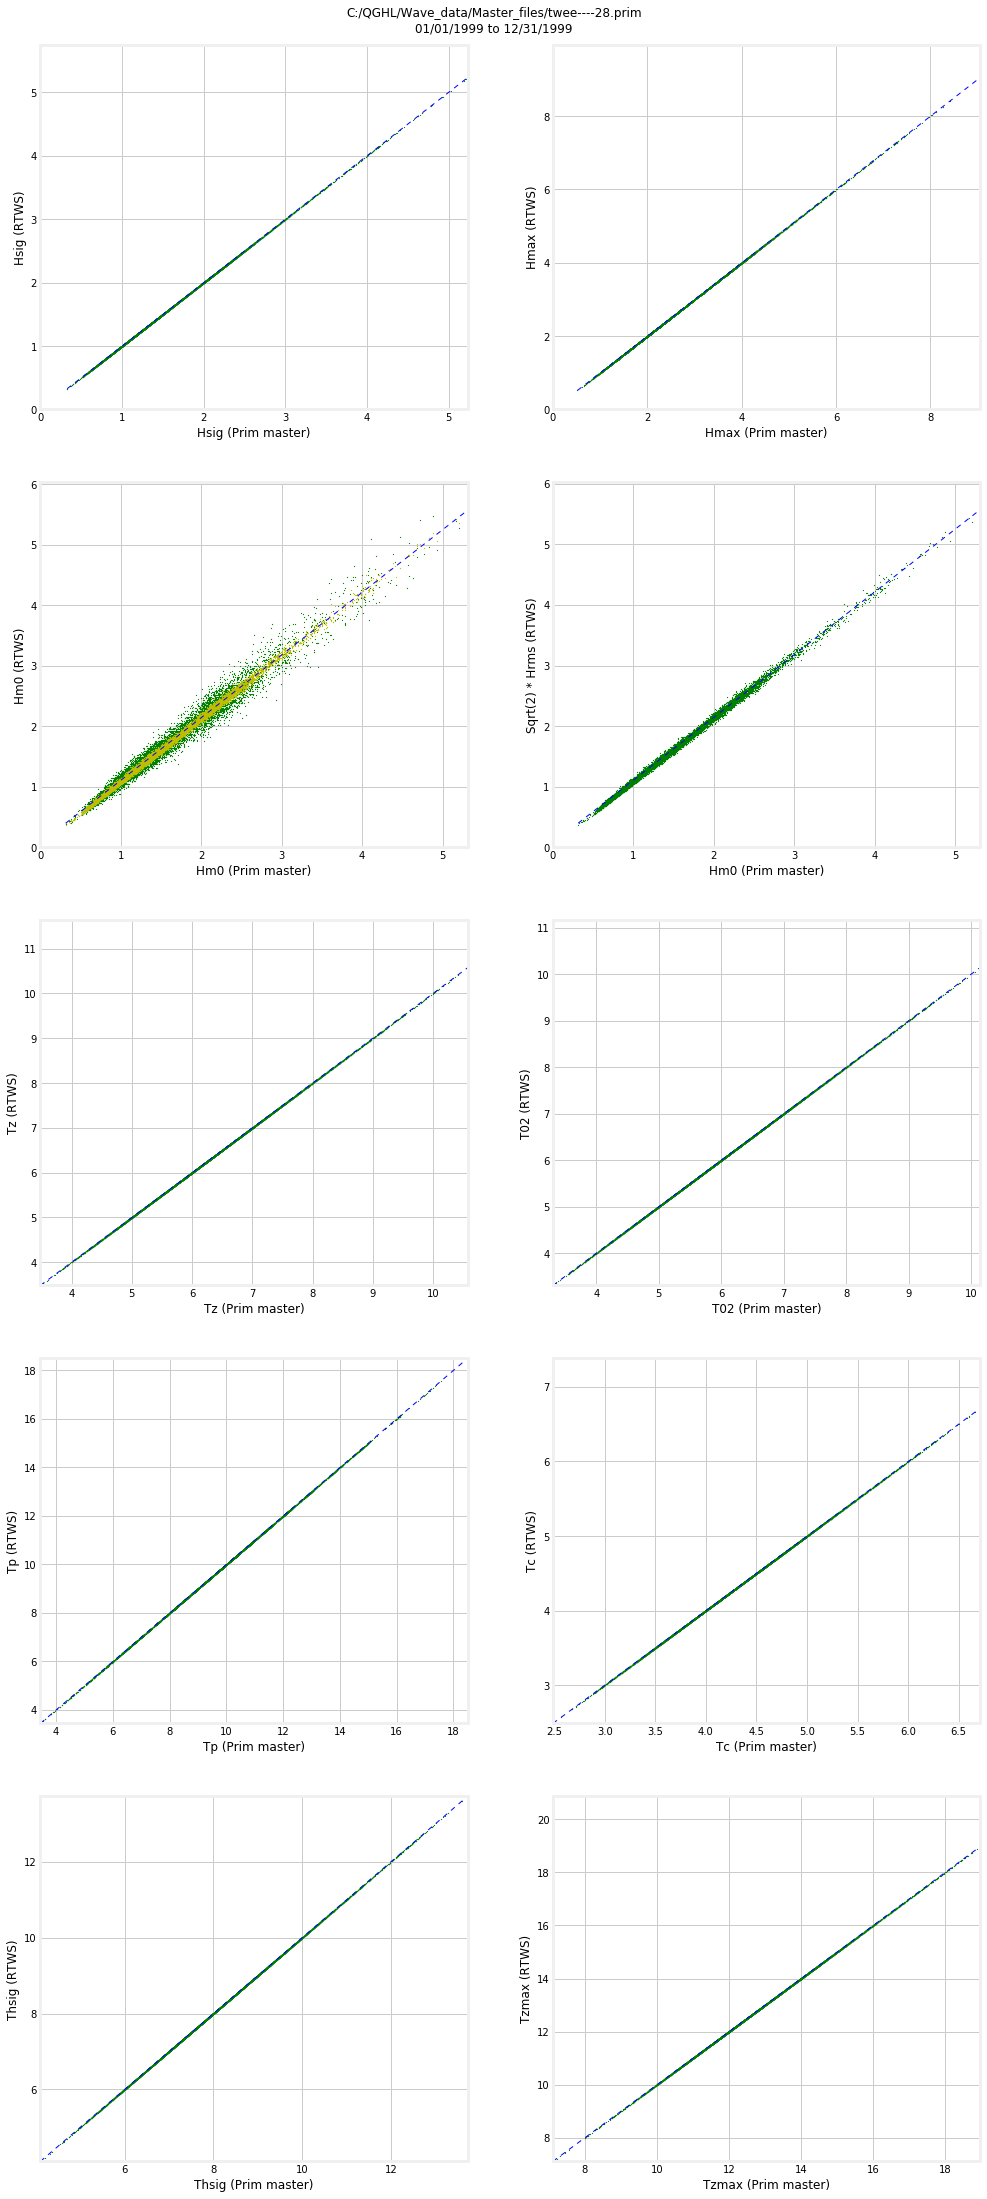

In [59]:
from matplotlib.dates import DateFormatter
from numpy.polynomial import Polynomial

# Display comparisons of main parameters between Prim master file and daily RTWS Prim files

details = Recs_Master_prim.describe()
plt.rcParams['axes.facecolor'] = 'white'
idx = recs_RTWS_prim.index.intersection(Recs_Master_prim.index)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(15,35), facecolor=(1, 1, 1))
fig.suptitle(Input_Prim_File+'\n'+(recs_RTWS_prim.loc[idx].index[0]).strftime('%m/%d/%Y')+' to '+(recs_RTWS_prim.loc[idx].index[-1]).strftime('%m/%d/%Y'))
#fig.tight_layout()
fig.subplots_adjust(top=0.965)

# Do scatter plot of Master file Hsig v's RTWS Hsig
idx = recs_RTWS_prim.index.intersection(Recs_Master_prim.index)
ax1.scatter(Recs_Master_prim.loc[idx].Hsig,recs_RTWS_prim.loc[idx].Hsig,s=0.5,c='g')
ax1.set_xlim(0,max(Recs_Master_prim.loc[idx].Hsig))
ax1.set_ylim(0,max(recs_RTWS_prim.loc[idx].Hsig)*1.1)
ax1.set_xlabel("Hsig (Prim master)")
ax1.set_ylabel("Hsig (RTWS)")

p = Polynomial.fit(Recs_Master_prim.loc[idx].Hsig,recs_RTWS_prim.loc[idx].Hsig, 1)
ax1.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file Hmax v's RTWS Hmax
##idx = recs_RTWS_prim.index.intersection(Recs_Master_prim.index)
ax2.scatter(Recs_Master_prim.loc[idx].Hmax,recs_RTWS_prim.loc[idx].Hmax,s=0.5,c='g')
ax2.set_xlim(0,max(Recs_Master_prim.loc[idx].Hmax))
ax2.set_ylim(0,max(recs_RTWS_prim.loc[idx].Hmax)*1.1)
ax2.set_xlabel("Hmax (Prim master)")
ax2.set_ylabel("Hmax (RTWS)")

p = Polynomial.fit(Recs_Master_prim.loc[idx].Hmax,recs_RTWS_prim.loc[idx].Hmax, 1)
ax2.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file Hm0 v's RTWS Hm0
ax3.scatter(Recs_Master_prim.loc[idx].Hm0,recs_RTWS_prim.loc[idx].Hm0,s=0.5,c='g')
ax3.scatter(Recs_Master_prim.loc[idx].Hm0,recs_RTWS_prim.loc[idx].Hrms*np.sqrt(2),s=0.5,c='y')
ax3.set_xlim(0,max(Recs_Master_prim.loc[idx].Hm0))
ax3.set_ylim(0,max(recs_RTWS_prim.loc[idx].Hm0)*1.1)
plt.legend(["Hm0 (RTWS)", "Hrms*np.sqrt(2) (RTWS)"],frameon=False)
ax3.set_xlabel("Hm0 (Prim master)")
ax3.set_ylabel("Hm0 (RTWS)")

p = Polynomial.fit(Recs_Master_prim.loc[idx].Hm0,recs_RTWS_prim.loc[idx].Hm0, 1)
ax3.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of  Master file Hm0 v's RTWS sqrt(2)* Hrms
##idx = recs_RTWS_prim.index.intersection(Recs_Master_prim.index)
ax4.scatter(Recs_Master_prim.loc[idx].Hm0,recs_RTWS_prim.loc[idx].Hrms*np.sqrt(2),s=0.5,c='g')
ax4.set_xlim(0,max(Recs_Master_prim.loc[idx].Hm0))
ax4.set_ylim(0,max(recs_RTWS_prim.loc[idx].Hrms*np.sqrt(2))*1.1)
ax4.set_xlabel("Hm0 (Prim master)")
ax4.set_ylabel("Sqrt(2) * Hrms (RTWS)")

p = Polynomial.fit(Recs_Master_prim.loc[idx].Hm0,recs_RTWS_prim.loc[idx].Hm0, 1)
ax4.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file Tz v's RTWS Tz
##idx = recs_RTWS_prim.index.intersection(Recs_Master_prim.index)
ax5.scatter(Recs_Master_prim.loc[idx].Tz,recs_RTWS_prim.loc[idx].Tz,s=0.5,c='g')
ax5.set_xlim(min(Recs_Master_prim.loc[idx].Tz),max(Recs_Master_prim.loc[idx].Tz))
ax5.set_ylim(min(recs_RTWS_prim.loc[idx].Tz),max(recs_RTWS_prim.loc[idx].Tz)*1.1)
ax5.set_xlabel("Tz (Prim master)")
ax5.set_ylabel("Tz (RTWS)")

p = Polynomial.fit(Recs_Master_prim.loc[idx].Tz,recs_RTWS_prim.loc[idx].Tz, 1)
ax5.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file T02 v's RTWS T02
##idx = recs_RTWS_prim.index.intersection(Recs_Master_prim.index)
ax6.scatter(Recs_Master_prim.loc[idx].T02,recs_RTWS_prim.loc[idx].T02,s=0.5,c='g')
ax6.set_xlim(min(Recs_Master_prim.loc[idx].T02),max(Recs_Master_prim.loc[idx].T02))
ax6.set_ylim(min(recs_RTWS_prim.loc[idx].T02),max(recs_RTWS_prim.loc[idx].T02)*1.1)
ax6.set_xlabel("T02 (Prim master)")
ax6.set_ylabel("T02 (RTWS)")

p = Polynomial.fit(Recs_Master_prim.loc[idx].T02,recs_RTWS_prim.loc[idx].T02, 1)
ax6.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file Tp v's RTWS Tp
##idx = recs_RTWS_prim.index.intersection(Recs_Master_prim.index)
ax7.scatter(Recs_Master_prim.loc[idx].Tp,recs_RTWS_prim.loc[idx].Tp,s=0.5,c='g')
ax7.set_xlim(min(Recs_Master_prim.loc[idx].Tp),max(Recs_Master_prim.loc[idx].Tp))
ax7.set_ylim(min(recs_RTWS_prim.loc[idx].Tp),max(recs_RTWS_prim.loc[idx].Tp))
ax7.set_xlabel("Tp (Prim master)")
ax7.set_ylabel("Tp (RTWS)")

p = Polynomial.fit(Recs_Master_prim.loc[idx].Tp,recs_RTWS_prim.loc[idx].Tp, 1)
ax7.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file Tc v's RTWS Tc
ax8.scatter(Recs_Master_prim.loc[idx].Tc,recs_RTWS_prim.loc[idx].Tc,s=0.5,c='g')
ax8.set_xlim(min(Recs_Master_prim.loc[idx].Tc),max(Recs_Master_prim.loc[idx].Tc))
ax8.set_ylim(min(recs_RTWS_prim.loc[idx].Tc),max(recs_RTWS_prim.loc[idx].Tc)*1.1)
ax8.set_xlabel("Tc (Prim master)")
ax8.set_ylabel("Tc (RTWS)")

p = Polynomial.fit(Recs_Master_prim.loc[idx].Tc,recs_RTWS_prim.loc[idx].Tc, 1)
ax8.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file Thsig v's RTWS Thsig
ax9.scatter(Recs_Master_prim.loc[idx].Thsig,recs_RTWS_prim.loc[idx].Thsig,s=0.5,c='g')
ax9.set_xlim(min(Recs_Master_prim.loc[idx].Thsig),max(Recs_Master_prim.loc[idx].Thsig))
ax9.set_ylim(min(recs_RTWS_prim.loc[idx].Thsig),max(recs_RTWS_prim.loc[idx].Thsig))
ax9.set_xlabel("Thsig (Prim master)")
ax9.set_ylabel("Thsig (RTWS)")

p = Polynomial.fit(Recs_Master_prim.loc[idx].Thsig,recs_RTWS_prim.loc[idx].Thsig, 1)
ax9.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file Tzmax v's RTWS Tzmax
ax10.scatter(Recs_Master_prim.loc[idx].Tzmax,recs_RTWS_prim.loc[idx].Tzmax,s=0.5,c='g')
ax10.set_xlim(min(Recs_Master_prim.loc[idx].Tzmax),max(Recs_Master_prim.loc[idx].Tzmax))
ax10.set_ylim(min(recs_RTWS_prim.loc[idx].Tzmax),max(recs_RTWS_prim.loc[idx].Tzmax)*1.1)
ax10.set_xlabel("Tzmax (Prim master)")
ax10.set_ylabel("Tzmax (RTWS)")

p = Polynomial.fit(Recs_Master_prim.loc[idx].Tzmax,recs_RTWS_prim.loc[idx].Tzmax, 1)
ax10.plot(*p.linspace(),lw=1.0,c="b",dashes=[5, 5, 5, 5])


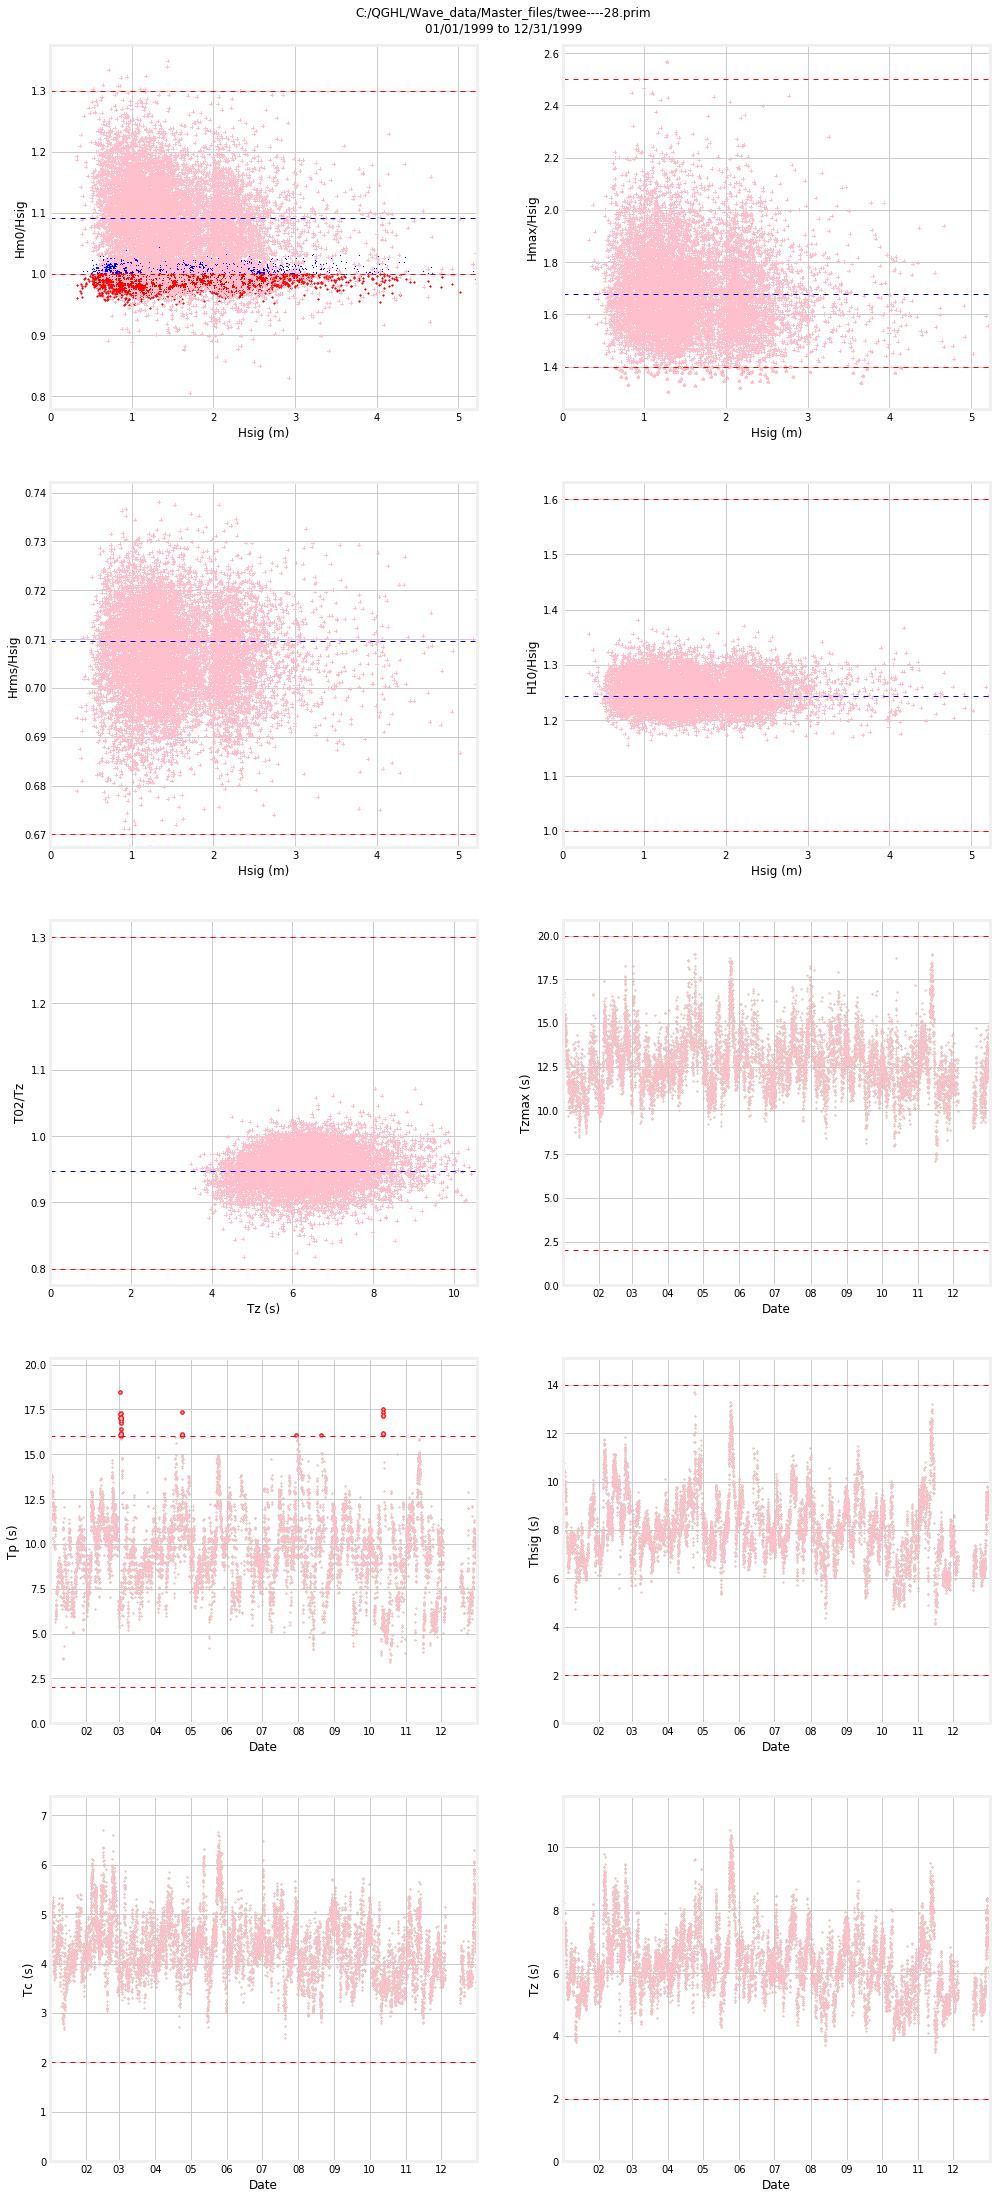

In [60]:
from matplotlib.dates import DateFormatter
from numpy.polynomial import Polynomial

# Display relationships in Prim master file

details = Recs_Master_prim.describe()
plt.rcParams['axes.facecolor'] = 'white'
idx = recs_RTWS_prim.index.intersection(Recs_Master_prim.index)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=(15,35), facecolor=(1, 1, 1))
fig.suptitle(Input_Prim_File+'\n'+(recs_RTWS_prim.loc[idx].index[0]).strftime('%m/%d/%Y')+' to '+(recs_RTWS_prim.loc[idx].index[-1]).strftime('%m/%d/%Y'))
#fig.tight_layout()
fig.subplots_adjust(top=0.965)

# Do scatter plot of Master file Hm0/Hsig ratio v's RTWS Hm0/Hsig ratio
ax1.scatter(Recs_Master_prim.loc[idx].Hsig,Recs_Master_prim.loc[idx].Hm0/Recs_Master_prim.loc[idx].Hsig,s=0.5,c='b')
suspect_Hm0_Hsig = Recs_Master_prim.loc[idx][~(Recs_Master_prim.loc[idx].Hm0/Recs_Master_prim.loc[idx].Hsig).between(1.0,1.3,inclusive=False)]
ax1.scatter(suspect_Hm0_Hsig.Hsig,suspect_Hm0_Hsig.Hm0/suspect_Hm0_Hsig.Hsig,s=2.5,c='r')
ax1.scatter(recs_RTWS_prim.loc[idx].Hsig,recs_RTWS_prim.loc[idx].Hm0/recs_RTWS_prim.loc[idx].Hsig,marker='+',s=1.0,c='pink')
mode = details.Hm0[5]/details.Hsig[5]
ax1.plot([0,max(Recs_Master_prim.loc[idx].Hsig)],[mode,mode],lw=1.0,c="b",dashes=[5, 5, 5, 5])
ax1.set_xlim(0,max(Recs_Master_prim.loc[idx].Hsig))
ax1.set_xlabel("Hsig (m)")
ax1.set_ylabel("Hm0/Hsig")
ax1.plot([0,max(Recs_Master_prim.loc[idx].Hsig)],[1.3,1.3],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax1.plot([0,max(Recs_Master_prim.loc[idx].Hsig)],[1.0,1.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file Hmax/Hsig ratio v's RTWS Hmax/Hsig ratio
ax2.scatter(Recs_Master_prim.loc[idx].Hsig,Recs_Master_prim.loc[idx].Hmax/Recs_Master_prim.loc[idx].Hsig,s=0.5,c='b')
suspect_Hmax_Hsig = Recs_Master_prim.loc[idx][~(Recs_Master_prim.loc[idx].Hmax/Recs_Master_prim.loc[idx].Hsig).between(1.4,2.5,inclusive=False)]
ax2.scatter(suspect_Hmax_Hsig.Hsig,suspect_Hmax_Hsig.Hmax/suspect_Hmax_Hsig.Hsig,marker='o',s=3.5,c='r')
ax2.scatter(recs_RTWS_prim.loc[idx].Hsig,recs_RTWS_prim.loc[idx].Hmax/recs_RTWS_prim.loc[idx].Hsig,marker='+',s=1.0,c='pink')
mode = details.Hmax[5]/details.Hsig[5]
ax2.plot([0,max(Recs_Master_prim.loc[idx].Hsig)],[mode,mode],lw=1.0,c="b",dashes=[5, 5, 5, 5])
ax2.set_xlim(0,max(Recs_Master_prim.loc[idx].Hsig))
#ax2.set_ylim(min(Recs_Master_prim.loc[idx].Hmax/Recs_Master_prim.loc[idx].Hsig),max(Recs_Master_prim.loc[idx].Hmax/Recs_Master_prim.loc[idx].Hsig))
ax2.set_xlabel("Hsig (m)")
ax2.set_ylabel("Hmax/Hsig")
ax2.plot([0,max(Recs_Master_prim.loc[idx].Hsig)],[2.5,2.5],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax2.plot([0,max(Recs_Master_prim.loc[idx].Hsig)],[1.4,1.4],lw=1.0,c="r",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file Hrms/Hsig ratio v's RTWS Hrms/Hsig ratio
ax3.scatter(Recs_Master_prim.loc[idx].Hsig,Recs_Master_prim.loc[idx].Hrms/Recs_Master_prim.loc[idx].Hsig,s=0.5,c='b')
suspect_Hrms_Hsig = Recs_Master_prim.loc[idx][~(Recs_Master_prim.loc[idx].Hrms/Recs_Master_prim.loc[idx].Hsig).between(0.67,0.75,inclusive=False)]
ax3.scatter(suspect_Hrms_Hsig.Hsig,suspect_Hrms_Hsig.Hrms/suspect_Hrms_Hsig.Hsig,marker='o',s=2.5,c='r')
ax3.scatter(recs_RTWS_prim.loc[idx].Hsig,recs_RTWS_prim.loc[idx].Hm/recs_RTWS_prim.loc[idx].Hsig,marker='+',s=1.0,c='pink')
mode = details.Hrms[5]/details.Hsig[5]
ax3.plot([0,max(Recs_Master_prim.loc[idx].Hsig)],[mode,mode],lw=1.0,c="b",dashes=[5, 5, 5, 5])
ax3.set_xlim(0,max(Recs_Master_prim.loc[idx].Hsig))
ax3.set_ylim(min(Recs_Master_prim.loc[idx].Hrms/Recs_Master_prim.loc[idx].Hsig),max(Recs_Master_prim.loc[idx].Hrms/Recs_Master_prim.loc[idx].Hsig))
ax3.set_xlabel("Hsig (m)")
ax3.set_ylabel("Hrms/Hsig")
ax3.plot([0,max(Recs_Master_prim.loc[idx].Hsig)],[0.95,0.95],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax3.plot([0,max(Recs_Master_prim.loc[idx].Hsig)],[0.67,0.67],lw=1.0,c="r",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file H10/Hsig ratio v's RTWS H10/Hsig ratio
ax4.scatter(Recs_Master_prim.loc[idx].Hsig,Recs_Master_prim.loc[idx].H10/Recs_Master_prim.loc[idx].Hsig,s=0.5,c='b')
suspect_H10_Hsig = Recs_Master_prim.loc[idx][~(Recs_Master_prim.loc[idx].H10/Recs_Master_prim.loc[idx].Hsig).between(1.0,1.6,inclusive=False)]
ax4.scatter(suspect_H10_Hsig.Hsig,suspect_H10_Hsig.Hrms/suspect_H10_Hsig.Hsig,marker='o',s=2.5,c='r')
ax4.scatter(recs_RTWS_prim.loc[idx].Hsig,recs_RTWS_prim.loc[idx].H10/recs_RTWS_prim.loc[idx].Hsig,marker='+',s=1.0,c='pink')
mode = details.H10[5]/details.Hsig[5]
ax4.plot([0,max(Recs_Master_prim.loc[idx].Hsig)],[mode,mode],lw=1.0,c="b",dashes=[5, 5, 5, 5])
ax4.set_xlim(0,max(Recs_Master_prim.loc[idx].Hsig))
#ax3.set_ylim(min(Recs_Master_prim.loc[idx].Hrms/Recs_Master_prim.loc[idx].Hsig),max(Recs_Master_prim.loc[idx].Hrms/Recs_Master_prim.loc[idx].Hsig))
ax4.set_xlabel("Hsig (m)")
ax4.set_ylabel("H10/Hsig")
ax4.plot([0,max(Recs_Master_prim.loc[idx].Hsig)],[1.6,1.6],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax4.plot([0,max(Recs_Master_prim.loc[idx].Hsig)],[1.0,1.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])

# Do scatter plot of Master file T02/Tz ratio v's RTWS T02/Tz ratio
ax5.scatter(Recs_Master_prim.loc[idx].Tz,Recs_Master_prim.loc[idx].T02/Recs_Master_prim.loc[idx].Tz,s=0.5,c='b')
suspect_T02_Tz = Recs_Master_prim.loc[idx][~(Recs_Master_prim.loc[idx].T02/Recs_Master_prim.loc[idx].Tz).between(0.8,1.3,inclusive=False)]
ax5.scatter(suspect_T02_Tz.Tz,suspect_T02_Tz.Hrms/suspect_T02_Tz.Tz,marker='o',s=2.5,c='r')
ax5.scatter(recs_RTWS_prim.loc[idx].Tz,recs_RTWS_prim.loc[idx].T02/recs_RTWS_prim.loc[idx].Tz,marker='+',s=1.0,c='pink')
mode = details.T02[5]/details.Tz[5]
ax5.plot([0,max(Recs_Master_prim.loc[idx].Tz)],[mode,mode],lw=1.0,c="b",dashes=[5, 5, 5, 5])
ax5.set_xlim(0,max(Recs_Master_prim.loc[idx].Tz))
#ax3.set_ylim(min(Recs_Master_prim.loc[idx].Hrms/Recs_Master_prim.loc[idx].Hsig),max(Recs_Master_prim.loc[idx].Hrms/Recs_Master_prim.loc[idx].Hsig))
ax5.set_xlabel("Tz (s)")
ax5.set_ylabel("T02/Tz")
ax5.plot([0,max(Recs_Master_prim.loc[idx].Tz)],[1.3,1.3],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax5.plot([0,max(Recs_Master_prim.loc[idx].Tz)],[0.8,0.8],lw=1.0,c="r",dashes=[5, 5, 5, 5])

# Do plot of Master file Tzmax and RTWS Tzmax
ax6.plot(Recs_Master_prim.Tzmax,lw=0,marker='o',ms=0.5,c='g')
suspect_Tzmax = Recs_Master_prim.loc[idx][~(Recs_Master_prim.loc[idx].Tzmax).between(2.0,20.0,inclusive=False)]
ax6.plot(suspect_Tzmax.Tzmax,lw=0,marker='o',ms=3.5,c='r')
ax6.plot(recs_RTWS_prim.loc[idx].Tzmax,lw=0,marker='o',ms=1.0,c='pink')
ax6.set_xlabel("Date")
ax6.set_ylabel("Tzmax (s)")
ax6.set_xlim(Recs_Master_prim.loc[idx].index[0],Recs_Master_prim.loc[idx].index[-1])
ax6.set_ylim(0,max(Recs_Master_prim.loc[idx].Tzmax)*1.1)
ax6.plot([Recs_Master_prim.loc[idx].index[0],Recs_Master_prim.loc[idx].index[-1]],[20.0,20.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax6.plot([Recs_Master_prim.loc[idx].index[0],Recs_Master_prim.loc[idx].index[-1]],[2.0,2.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])
myFmt = DateFormatter("%m")
ax6.xaxis.set_major_formatter(myFmt)

# Do plot of Master file Tp and RTWS Tp
ax7.plot(Recs_Master_prim.Tp,lw=0,marker='o',ms=0.5,c='g')
suspect_Tp = Recs_Master_prim.loc[idx][~(Recs_Master_prim.loc[idx].Tp).between(2.0,16.0,inclusive=False)]
ax7.plot(suspect_Tp.Tp,lw=0,marker='o',ms=3.5,c='r')
ax7.plot(recs_RTWS_prim.loc[idx].Tp,lw=0,marker='o',ms=1.0,c='pink')
ax7.set_xlabel("Date")
ax7.set_ylabel("Tp (s)")
ax7.set_xlim(Recs_Master_prim.loc[idx].index[0],Recs_Master_prim.loc[idx].index[-1])
ax7.set_ylim(0,max(Recs_Master_prim.loc[idx].Tp)*1.1)
ax7.plot([Recs_Master_prim.loc[idx].index[0],Recs_Master_prim.loc[idx].index[-1]],[16,16],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax7.plot([Recs_Master_prim.loc[idx].index[0],Recs_Master_prim.loc[idx].index[-1]],[2,2],lw=1.0,c="r",dashes=[5, 5, 5, 5])
myFmt = DateFormatter("%m")
ax7.xaxis.set_major_formatter(myFmt)

# Do plot of Master file Thsig and RTWS Thsig
ax8.plot(Recs_Master_prim.Thsig,lw=0,marker='o',ms=0.5,c='g')
suspect_Thsig = Recs_Master_prim.loc[idx][~(Recs_Master_prim.loc[idx].Thsig).between(2.0,14.0,inclusive=False)]
ax8.plot(suspect_Thsig.Thsig,lw=0,marker='o',ms=3.5,c='r')
ax8.plot(recs_RTWS_prim.loc[idx].Thsig,lw=0,marker='o',ms=1.0,c='pink')
ax8.set_xlabel("Date")
ax8.set_ylabel("Thsig (s)")
ax8.set_xlim(Recs_Master_prim.loc[idx].index[0],Recs_Master_prim.loc[idx].index[-1])
ax8.set_ylim(0,max(Recs_Master_prim.loc[idx].Thsig)+max(Recs_Master_prim.loc[idx].Thsig)/10)
ax8.plot([Recs_Master_prim.loc[idx].index[0],Recs_Master_prim.loc[idx].index[-1]],[14,14],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax8.plot([Recs_Master_prim.loc[idx].index[0],Recs_Master_prim.loc[idx].index[-1]],[2,2],lw=1.0,c="r",dashes=[5, 5, 5, 5])
myFmt = DateFormatter("%m")
ax8.xaxis.set_major_formatter(myFmt)

# Do plot of Master file Tc and RTWS Tc
ax9.plot(Recs_Master_prim.Tc,lw=0,marker='o',ms=0.5,c='g')
suspect_Tc = Recs_Master_prim.loc[idx][~(Recs_Master_prim.loc[idx].Tc).between(2.0,14.0,inclusive=False)]
ax9.plot(suspect_Tc.Tc,lw=0,marker='o',ms=3.5,c='r')
ax9.plot(recs_RTWS_prim.loc[idx].Tc,lw=0,marker='o',ms=1.0,c='pink')
ax9.set_xlabel("Date")
ax9.set_ylabel("Tc (s)")
ax9.set_xlim(Recs_Master_prim.loc[idx].index[0],Recs_Master_prim.loc[idx].index[-1])
ax9.set_ylim(0,max(Recs_Master_prim.loc[idx].Tc)*1.1)
ax9.plot([Recs_Master_prim.loc[idx].index[0],Recs_Master_prim.loc[idx].index[-1]],[14,14],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax9.plot([Recs_Master_prim.loc[idx].index[0],Recs_Master_prim.loc[idx].index[-1]],[2,2],lw=1.0,c="r",dashes=[5, 5, 5, 5])
myFmt = DateFormatter("%m")
ax9.xaxis.set_major_formatter(myFmt)

# Do plot of Master file Tz and RTWS Tz
ax10.plot(Recs_Master_prim.Tz,lw=0,marker='o',ms=0.5,c='g')
suspect_Tz = Recs_Master_prim.loc[idx][~(Recs_Master_prim.loc[idx].Tz).between(2.0,14.0,inclusive=False)]
ax10.plot(suspect_Tz.Tz,lw=0,marker='o',ms=3.5,c='r')
ax10.plot(recs_RTWS_prim.loc[idx].Tz,lw=0,marker='o',ms=1.0,c='pink')
ax10.set_xlabel("Date")
ax10.set_ylabel("Tz (s)")
ax10.set_xlim(Recs_Master_prim.loc[idx].index[0],Recs_Master_prim.loc[idx].index[-1])
ax10.set_ylim(0,max(Recs_Master_prim.loc[idx].Tz)*1.1)
ax10.plot([Recs_Master_prim.loc[idx].index[0],Recs_Master_prim.loc[idx].index[-1]],[14,14],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax10.plot([Recs_Master_prim.loc[idx].index[0],Recs_Master_prim.loc[idx].index[-1]],[2,2],lw=1.0,c="r",dashes=[5, 5, 5, 5])
myFmt = DateFormatter("%m")
ax10.xaxis.set_major_formatter(myFmt)

In [ ]:
%matplotlib inline

import numpy as np
import scipy.stats as stats
import pylab as plt

from itertools import chain 
from scipy.stats import norm,rayleigh,skew,kurtosis

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,20), facecolor=(1, 1, 1))
fig.suptitle('Distribution of ratio values for Master File and RTWS daily files'+'\n'
             +(recs_RTWS_prim.loc[idx].index[0]).strftime('%m/%d/%Y')+' to '
             +(recs_RTWS_prim.loc[idx].index[-1]).strftime('%m/%d/%Y'))
#fig.tight_layout()
fig.subplots_adjust(top=0.955)
      
# Plot distribution of Hm0/Hsig values
x_val = recs_RTWS_prim.loc[idx].Hm0/recs_RTWS_prim.loc[idx].Hsig
x_val_1 = Recs_Master_prim.loc[idx].Hm0/Recs_Master_prim.loc[idx].Hsig
binwidth = 0.02

# Fit a normal distribution to the data:
mu, std = norm.fit(x_val)
mu1, std1 = norm.fit(x_val)
plus_spike = np.median(x_val) + std*3
minus_spike = np.median(x_val) - std*3

# Plot the histograms.
count,bins,patches = ax1.hist(x_val_1, bins=np.arange(min(x_val_1), max(x_val_1) + binwidth, binwidth),
         density=1,edgecolor='black',facecolor='xkcd:pink',alpha=0.75, hatch='/', label='Master File')

ax1.hist(x_val, bins=np.arange(min(x_val), max(x_val) + binwidth, binwidth),
         density=1,edgecolor='black',facecolor='xkcd:aquamarine',alpha=0.5, label='RTWS')

ax1.legend(loc='upper right',frameon=False)

# Plot the PDF.
xmin, xmax = ax1.set_xlim()
ymin, ymax = ax1.set_ylim()
x = np.linspace(xmin, xmax, len(x_val))
median = x_val.describe()[5]
ax1.plot(x,norm.pdf(x, mu, std), color='orange',linewidth=1.5)
ax1.set_xlabel('Hm0/Hsig ratios')
ax1.set_ylabel('Probability')

ax1.text(plus_spike,max(count*0.9), r'3$\sigma$',fontsize=15,horizontalalignment='center')
ax1.plot([plus_spike,plus_spike],[0.0,max(count*0.9)],lw=0.75,c="black",dashes=[5, 5, 5, 5])
ax1.text(minus_spike,max(count*0.9), r'-3$\sigma$',fontsize=15,horizontalalignment='center')
ax1.plot([minus_spike,minus_spike],[0.0,max(count*0.9)],lw=0.75,c="black",dashes=[5, 5, 5, 5])
ax1.text(median,max(count*0.9),'Median',fontsize=15,horizontalalignment='center')
ax1.plot([median,median],[0,max(count*0.9)],lw=0.75,c="blue",dashes=[5, 5, 5, 5])
ax1.set_xlim(left=minus_spike-std,right=plus_spike+std)

# Plot distribution of Hmax/Hsig values
x_val = recs_RTWS_prim.loc[idx].Hmax/recs_RTWS_prim.loc[idx].Hsig
x_val_1 = Recs_Master_prim.loc[idx].Hmax/Recs_Master_prim.loc[idx].Hsig
binwidth = 0.04

# Fit a normal distribution to the data:
mu, std = norm.fit(x_val)
plus_spike = np.median(x_val) + std*3
minus_spike = np.median(x_val) - std*3

# Plot the histograms.
count,bins,patches = ax2.hist(x_val_1, bins=np.arange(min(x_val_1), max(x_val_1) + binwidth, binwidth),
         density=1,edgecolor='black',facecolor='xkcd:pink',alpha=0.75, hatch='/', label='Master File')

ax2.hist(x_val, bins=np.arange(min(x_val), max(x_val) + binwidth, binwidth),
         density=1,edgecolor='black',facecolor='xkcd:aquamarine',alpha=0.5, label='RTWS')

ax2.legend(loc='upper right',frameon=False)

# Plot the PDF.
xmin, xmax = ax2.set_xlim()
ymin, ymax = ax2.set_ylim()
x = np.linspace(xmin, xmax, len(x_val))
median = x_val.describe()[5]
ax2.plot(x,norm.pdf(x, mu, std), color='orange',linewidth=1.5)
ax2.set_xlabel('Hmax/Hsig ratios')
ax2.set_ylabel('Probability')

ax2.text(plus_spike,max(count*0.9), r'3$\sigma$',fontsize=15,horizontalalignment='center')
ax2.plot([plus_spike,plus_spike],[0.0,max(count*0.9)],lw=0.75,c="black",dashes=[5, 5, 5, 5])
ax2.text(minus_spike,max(count*0.9), r'-3$\sigma$',fontsize=15,horizontalalignment='center')
ax2.plot([minus_spike,minus_spike],[0.0,max(count*0.9)],lw=0.75,c="black",dashes=[5, 5, 5, 5])
ax2.text(median,max(count*0.9),'Median',fontsize=15,horizontalalignment='center')
ax2.plot([median,median],[0,max(count*0.9)],lw=0.75,c="blue",dashes=[5, 5, 5, 5])
ax2.set_xlim(left=minus_spike-std,right=plus_spike+std)

# Plot distribution of Hrms/Hsig values
x_val = recs_RTWS_prim.loc[idx].Hm/recs_RTWS_prim.loc[idx].Hsig
x_val_1 = Recs_Master_prim.loc[idx].Hrms/Recs_Master_prim.loc[idx].Hsig
binwidth = 0.01

# Fit a normal distribution to the data:
mu, std = norm.fit(x_val)
plus_spike = np.median(x_val) + std*3
minus_spike = np.median(x_val) - std*3

# Plot the histograms.
count,bins,patches = ax3.hist(x_val_1, bins=np.arange(min(x_val_1), max(x_val_1) + binwidth, binwidth),
         density=1,edgecolor='black',facecolor='xkcd:pink',alpha=0.75, hatch='/', label='Master File')

ax3.hist(x_val, bins=np.arange(min(x_val), max(x_val) + binwidth, binwidth),
         density=1,edgecolor='black',facecolor='xkcd:aquamarine',alpha=0.5, label='RTWS')

ax3.legend(loc='upper right',frameon=False)

# Plot the PDF.
xmin, xmax = ax3.set_xlim()
ymin, ymax = ax3.set_ylim()
x = np.linspace(xmin, xmax, len(x_val))
median = x_val.describe()[5]

ax3.plot(x,norm.pdf(x, mu, std), color='orange',linewidth=1.5)
ax3.set_xlabel('Hrms/Hsig ratios')
ax3.set_ylabel('Probability')

ax3.text(plus_spike,max(count*0.9), r'3$\sigma$',fontsize=15,horizontalalignment='center')
ax3.plot([plus_spike,plus_spike],[0.0,max(count*0.9)],lw=0.75,c="black",dashes=[5, 5, 5, 5])
ax3.text(minus_spike,max(count*0.9), r'-3$\sigma$',fontsize=15,horizontalalignment='center')
ax3.plot([minus_spike,minus_spike],[0.0,max(count*0.9)],lw=0.75,c="black",dashes=[5, 5, 5, 5])
ax3.text(median,max(count*0.9),'Median',fontsize=15,horizontalalignment='center')
ax3.plot([median,median],[0,max(count*0.9)],lw=0.75,c="blue",dashes=[5, 5, 5, 5])
ax3.set_xlim(left=minus_spike-std,right=plus_spike+std)

# Plot distribution of H10/Hsig values
x_val = recs_RTWS_prim.loc[idx].H10/recs_RTWS_prim.loc[idx].Hsig
x_val_1 = Recs_Master_prim.loc[idx].H10/Recs_Master_prim.loc[idx].Hsig
binwidth = 0.02

# Fit a normal distribution to the data:
mu, std = norm.fit(x_val)
plus_spike = np.median(x_val) + std*3
minus_spike = np.median(x_val) - std*3

# Plot the histograms.
count,bins,patches = ax4.hist(x_val_1, bins=np.arange(min(x_val_1), max(x_val_1) + binwidth, binwidth),
         density=1,edgecolor='black',facecolor='xkcd:pink',alpha=0.75, hatch='/',label='Master File')

ax4.hist(x_val, bins=np.arange(min(x_val), max(x_val) + binwidth, binwidth),
         density=1,edgecolor='black',facecolor='xkcd:aquamarine',alpha=0.5,label='RTWS')

ax4.legend(loc='upper right',frameon=False)

# Plot the PDF.
xmin, xmax = ax4.set_xlim()
ymin, ymax = ax4.set_ylim()
x = np.linspace(xmin, xmax, len(x_val))
median = x_val.describe()[5]

ax4.plot(x,norm.pdf(x, mu, std), color='orange',linewidth=1.5)
ax4.set_xlabel('H10/Hsig ratios')
ax4.set_ylabel('Probability')

ax4.text(plus_spike,max(count*0.9), r'3$\sigma$',fontsize=15,horizontalalignment='center')
ax4.plot([plus_spike,plus_spike],[0.0,max(count*0.9)],lw=0.75,c="black",dashes=[5, 5, 5, 5])
ax4.text(minus_spike,max(count*0.9), r'-3$\sigma$',fontsize=15,horizontalalignment='center')
ax4.plot([minus_spike,minus_spike],[0.0,max(count*0.9)],lw=0.75,c="black",dashes=[5, 5, 5, 5])
ax4.text(median,max(count*0.9),'Median',fontsize=15,horizontalalignment='center')
ax4.plot([median,median],[0,max(count*0.9)],lw=0.75,c="blue",dashes=[5, 5, 5, 5])
ax4.set_xlim(left=minus_spike-std,right=plus_spike+std)

plt.show() 

In [ ]:
print( stats.skew(x_val) )

In [ ]:
# Apply CLT to data - calculate sample mean for each day of the week (i.e. 7 means)
x_val_dates = recs_RTWS_prim.loc[idx].index

week_day = []
for i in range(7):
    week_day.append(np.median(x_val.loc[x_val_dates.weekday == i]))
    print(i)

z_critical = stats.norm.ppf(q = 0.975)  # Get the z-critical value*

print("z-critical value:")              # Check the z-critical value
print(z_critical)                        

pop_stdev = x_val.std()  # Get the population standard deviation

margin_of_error = z_critical * (pop_stdev/np.sqrt(len(x_val)))

sample_mean = np.mean(week_day)
confidence_interval = (sample_mean - margin_of_error,
                       sample_mean + margin_of_error)  

print("Confidence interval:")
print(confidence_interval)

In [ ]:
sample_size = len(x_val)

intervals = []
sample_means = []

for i in range(7):
    sample = x_val.loc[x_val_dates.weekday == i]
    sample_mean = np.mean(sample)
    sample_means.append(sample_mean)
    
    sample_len = len(sample)

    t_critical = stats.t.ppf(q = 0.975,df = sample_len-1)  # Get the t-critical value         

    pop_stdev = x_val.std()  # Get the population standard deviation

    margin_of_error = t_critical * (pop_stdev/np.sqrt(sample_len))

    confidence_interval = (sample_mean - margin_of_error,
                           sample_mean + margin_of_error)
    print(confidence_interval)
    
    intervals.append(confidence_interval)

In [ ]:
plt.figure(figsize=(9,9))

plt.errorbar(x=np.arange(0, 7, 1), 
             y=sample_means, 
             yerr=[(top-bot)/2 for top,bot in intervals],
             fmt='o')

plt.hlines(xmin=0, xmax=6.0,
           y=np.mean(x_val), 
           linewidth=2.0,
           color="red")

In [ ]:
print(np.mean(Recs_Master_prim.Hm0/Recs_Master_prim.Hsig),np.mean(recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].Hm0/recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].Hsig))

In [ ]:
stats.ttest_1samp(a= recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].Hm0/recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].Hsig,               # Sample data
                 popmean= (Recs_Master_prim.Hm0/Recs_Master_prim.Hsig).mean())  # Pop mean

In [ ]:
stats.t.ppf(q=0.025,  # Quantile to check
            df=len(recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0])-1)  # Degrees of freedom

In [ ]:
stats.t.ppf(q=0.975,  # Quantile to check
            df=len(recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0])-1)  # Degrees of freedom

In [ ]:
stats.t.cdf(x= -5.181322109898758,      # T-test statistic
               df= len(recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0])-1) * 2   # Mupltiply by two for two tailed test*

In [ ]:
sigma = (recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].Hm0/recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].Hsig).std()/np.sqrt(len(recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0]))  # Sample stdev/sample size

stats.t.interval(0.95,                        # Confidence level
                 df = len(recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0])-1,                     # Degrees of freedom
                 loc = (recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].Hm0/recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].Hsig).mean(), # Sample mean
                 scale= sigma)                # Standard dev estimate

In [ ]:
sigma = (recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].Hm0/recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].Hsig).std()/np.sqrt(len(recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0]))  # Sample stdev/sample size

stats.t.interval(0.99,                        # Confidence level
                 df = len(recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0])-1,                     # Degrees of freedom
                 loc = (recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].Hm0/recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].Hsig).mean(), # Sample mean
                 scale= sigma)                # Standard dev estimate

In [ ]:
from scipy.stats import chi2

observed = recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].Hm0/recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].Hsig

expected = Recs_Master_prim.Hm0/Recs_Master_prim.Hsig

chi_squared_stat = (((observed-expected)**2)/expected).sum()

print(chi_squared_stat)

crit = stats.chi2.ppf(q = 0.95, # Find the critical value for 95% confidence*
                      df = 1)   # Df = number of variable categories - 1

print("Critical value")
print(crit)

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat,  # Find the p-value
                             df=1)
print("P value")
print(p_value)

In [ ]:
stats.chisquare(f_obs= np.mean(observed),   # Array of observed counts
                f_exp= np.mean(expected))   # Array of expected counts

In [ ]:
recs_RTWS_prim = pd.DataFrame([])
recs_RTWS_prim = get_RTWS_PRIM_data(recs_RTWS_prim)

recs_RTWS_seco = pd.DataFrame([])
recs_RTWS_seco = get_RTWS_SECO_data(recs_RTWS_seco)

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,10), facecolor=(1, 1, 1))
details = recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].describe()
mode = details.Hm0[5]/details.Hsig[5]

ax1.scatter(recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].Hsig,
            recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].Hm0/recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].Hsig,s=1,c='b')
#ax1.scatter(recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].Hsig,
#            recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].Hm*np.sqrt(2)/recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].Hsig,s=1,c='b')

ax1.set_xlim(0,max(Recs_Master_prim.Hsig))
ax1.set_ylim(bottom=0.5,top=1.5)
ax1.set_xlabel("Hsig (m)")
ax1.set_ylabel("Hm0/Hsig")

ax1.set_title("RTWS Daily Prim Files ("+str(recs_RTWS_prim.index.year[0])+")")
ax1.plot([0,max(Recs_Master_prim.loc[Recs_Master_prim.Hsig>0].Hsig)],[mode,mode],lw=1.0,c="b",dashes=[5, 5, 5, 5])
ax1.plot([0,max(Recs_Master_prim.loc[Recs_Master_prim.Hsig>0].Hsig)],[1.3,1.3],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax1.plot([0,max(Recs_Master_prim.loc[Recs_Master_prim.Hsig>0].Hsig)],[1.0,1.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])
print(np.mean(recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].Hm0/recs_RTWS_prim.loc[recs_RTWS_prim.Hsig>0].Hsig))
      
details = Recs_Master_prim.loc[Recs_Master_prim.Hsig>0].describe()
mode = details.Hm0[5]/details.Hsig[5]

year_val = recs_RTWS_prim.index.year[0]
#ax2.scatter(Recs_Master_prim.Hsig,Recs_Master_prim.Hm0 / Recs_Master_prim.Hsig,s=1,c='b')
ax2.scatter(Recs_Master_prim.Hsig,Recs_Master_prim.Hm0/Recs_Master_prim.Hsig,s=1,c='b') 
ax2.scatter(Recs_Master_prim[Recs_Master_prim.index.year==year_val].Hsig,
            Recs_Master_prim.loc[Recs_Master_prim.index.year==year_val].Hm0 
            / Recs_Master_prim[Recs_Master_prim.index.year==year_val].Hsig,s=1,c='r')
plt.legend(["All data",str(recs_RTWS_prim.index.year[0])],frameon=False)

ax2.plot([0,max(Recs_Master_prim.loc[Recs_Master_prim.Hsig>0].Hsig)],[mode,mode],lw=1.0,c="b",dashes=[5, 5, 5, 5])
ax2.plot([0,max(Recs_Master_prim.loc[Recs_Master_prim.Hsig>0].Hsig)],[1.3,1.3],lw=1.0,c="r",dashes=[5, 5, 5, 5])
ax2.plot([0,max(Recs_Master_prim.loc[Recs_Master_prim.Hsig>0].Hsig)],[1.0,1.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])

ax2.set_xlim(0,max(Recs_Master_prim.Hsig))
ax2.set_ylim(bottom=0.5,top=1.5)
ax2.set_xlabel("Hsig (m)")
ax2.set_ylabel("Hm0/Hsig")
ax2.set_title("Prim Master File ("+str(Recs_Master_prim.index.year[0])+' to '+str(Recs_Master_prim.index.year[-1])+")")

print(np.mean(Recs_Master_prim[Recs_Master_prim.index.year==year_val].Hm0 
              / Recs_Master_prim[Recs_Master_prim.index.year==year_val].Hsig))

plt.show()

In [15]:
# Merge the PRIM and DSECO master files on common dates
merged_masters = pd.merge(left=Recs_Master_prim,right=Recs_Master_dseco, left_on=Recs_Master_prim.index, right_on=Recs_Master_dseco.index)
print(len(Recs_Master_prim))
print(len(Recs_Master_dseco))
print(len(merged_masters))


370420
370811
342242


In [86]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
merged_masters

key_0      Hsig     Thsig      Hrms      Hmax        Tc        Tz       H10      Th10      Thmax      Tzmax     Hm0_x     T02_x         Tp       EPS  Npts      Elapse  Hm0_y     T02_y     Pdens        SST     Vacc     Xacc     Yacc      Orient     Inclin    TP_Buoy     Avg_Dir    Peak_Dir  Corr_to_True                                                                                                                                                                                                                                                                                        jdirn                                                                                                                                                                                                                                                                                                                                                     jrpower                                                                                                                                                                                                                                                                                                jspread
0      1995-01-13 14:00:00  1.711143  6.225428  1.204876  2.999992  4.151028  5.112038  2.229021  6.435559  5.698345   10.705777  1.865099  5.112020  5.651841   0.455317  2048  [1250, 0]   1.83   5.128205  1.929379  24.650000  0.16750  0.08125  0.00000  313.582611 -59.060402  4.761905   107.222038  119.203178  11.600724     [146, 223, 67, 61, 58, 79, 97, 64, 46, 56, 49, 30, 68, 35, 59, 56, 58, 64, 70, 67, 66, 75, 77, 82, 77, 90, 89, 92, 87, 91, 85, 95, 93, 87, 100, 97, 97, 95, 100, 97, 97, 98, 98, 110, 102, 93, 98, 102, 104, 81, 102, 89, 102, 92, 94, 76, 94, 91, 87, 73, 99, 94, 87, 93]                   [1091, 964, 959, 913, 1038, 975, 910, 887, 621, 464, 534, 607, 350, 347, 379, 168, 149, 44, 77, 97, 38, 119, 39, 102, 1, 0, 108, 141, 270, 361, 365, 386, 399, 475, 440, 432, 464, 586, 649, 545, 655, 666, 718, 694, 717, 722, 801, 843, 794, 796, 878, 923, 941, 955, 932, 892, 1025, 962, 1099, 997, 1049, 1091, 1092, 1148]                             [161, 171, 148, 144, 166, 137, 167, 137, 135, 114, 108, 156, 76, 103, 102, 74, 73, 55, 68, 59, 62, 71, 60, 73, 53, 47, 63, 52, 64, 76, 59, 77, 67, 87, 78, 73, 79, 106, 107, 81, 92, 93, 103, 107, 107, 106, 93, 104, 100, 105, 117, 131, 128, 137, 119, 109, 114, 109, 138, 143, 129, 124, 130, 136]
1      1995-01-13 15:00:00  1.764650  6.157369  1.251558  3.049996  4.139610  5.242599  2.263997  6.087107  5.999141   10.359783  1.882170  5.038235  6.163641   0.467398  2048  [1250, 0]   1.87   5.063291  2.038467  24.700001  0.16500  0.08750  0.00000  111.089806 -58.357304  5.000000   110.098152  120.234970  11.600723     [237, 6, 39, 99, 84, 69, 73, 85, 76, 60, 61, 71, 56, 69, 61, 59, 60, 63, 72, 66, 70, 75, 77, 84, 87, 85, 80, 88, 90, 94, 86, 91, 95, 93, 96, 106, 103, 98, 104, 100, 98, 94, 100, 105, 113, 104, 105, 106, 97, 100, 93, 94, 105, 96, 101, 87, 94, 97, 76, 101, 107, 109, 97, 104]            [1208, 1020, 962, 936, 869, 1012, 826, 751, 497, 458, 474, 578, 364, 254, 323, 326, 84, 120, 128, 56, 126, 80, 44, 60, 0, 51, 118, 139, 284, 336, 324, 369, 366, 405, 476, 438, 457, 526, 524, 602, 548, 614, 609, 714, 743, 655, 757, 777, 801, 813, 844, 925, 941, 924, 970, 968, 943, 983, 1050, 1039, 1069, 1123, 1092, 1192]                           [157, 163, 141, 153, 127, 121, 143, 144, 120, 119, 96, 101, 82, 72, 114, 87, 66, 73, 68, 62, 64, 62, 53, 53, 57, 58, 49, 57, 63, 72, 67, 69, 63, 77, 85, 76, 81, 96, 85, 101, 90, 81, 94, 106, 105, 105, 115, 113, 106, 107, 107, 111, 116, 108, 116, 127, 108, 123, 130, 130, 129, 126, 124, 134]   
2      1995-01-13 16:00:00  1.691308  6.366799  1.212668  2.729994  4.213390  5.376684  2.150328  6.458743  6.232250   10.412972  1.827199  5.141242  5.975784   0.484325  2048  [1250, 0]   1.89   5.194805  3.294314  24.700001  0.16500  0.08375 -0.00125  140.6200

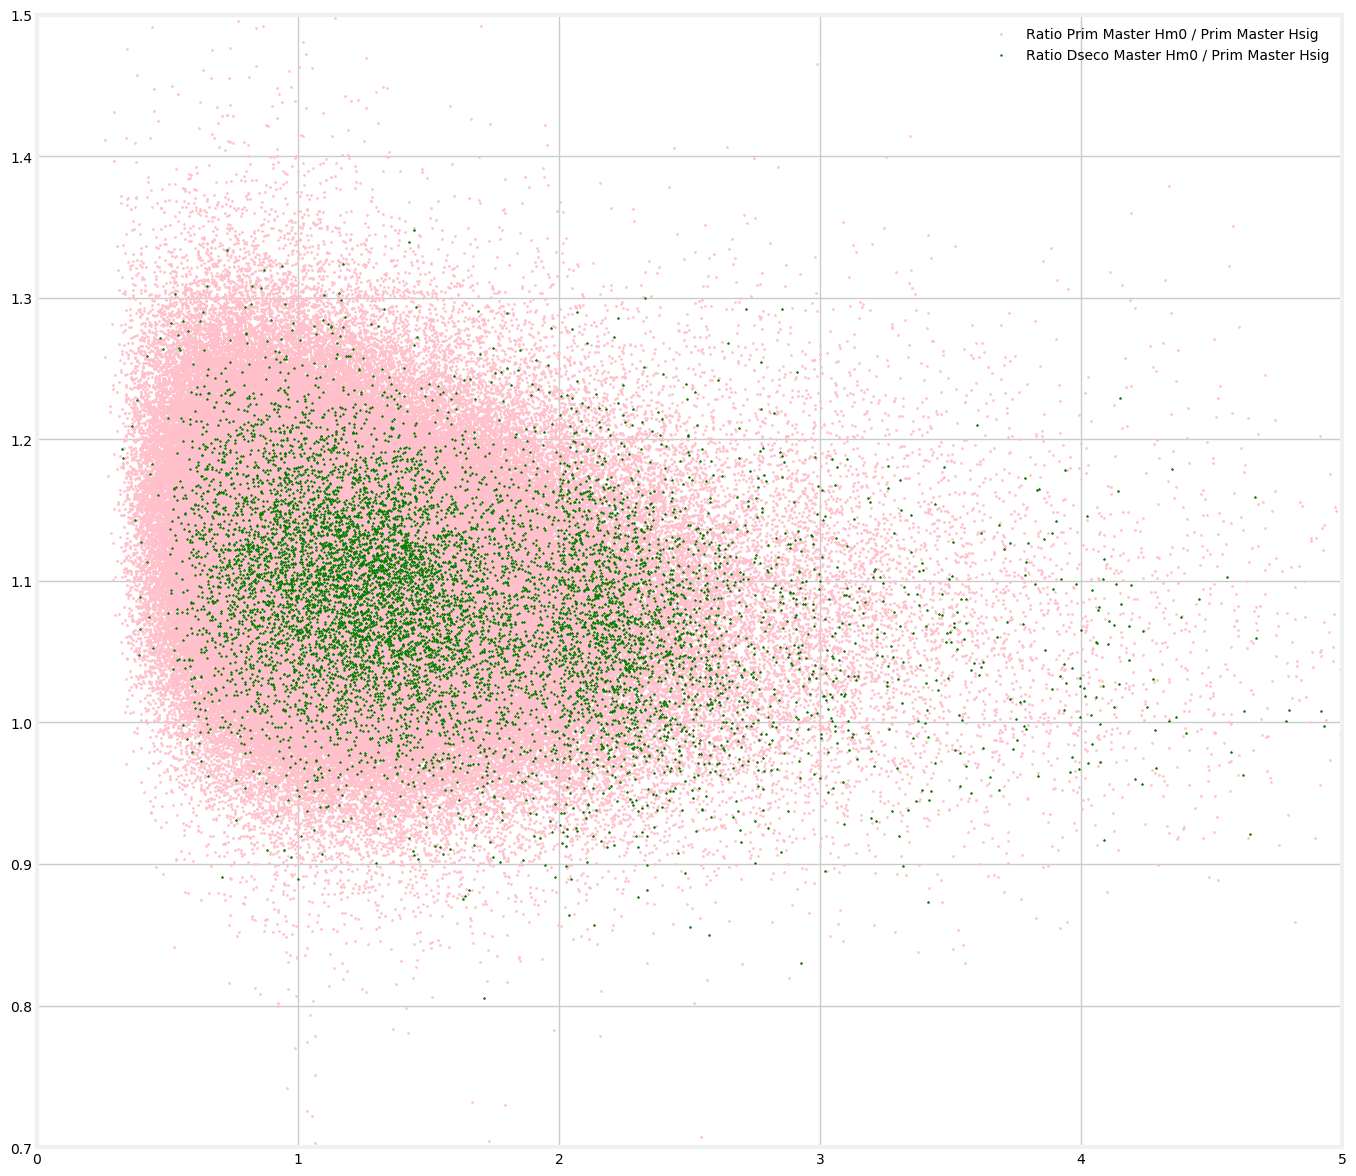

In [113]:
plt.figure(figsize=(15,15),dpi=100)
#plt.scatter(merged_masters.Hsig,merged_masters.Hm0_x/merged_masters.Hsig,s=1,c='r')
plt.scatter(merged_masters.Hsig,merged_masters.Hm0_y/merged_masters.Hsig,marker='o', s=2,c='pink')
plt.scatter(recs_RTWS_prim.Hsig,recs_RTWS_prim.Hm0/recs_RTWS_prim.Hsig,marker='*',s=2,c='green')
plt.xlim(left=0,right=5)
plt.ylim(bottom=0.7,top=1.5)
plt.legend(['Ratio Prim Master Hm0 / Prim Master Hsig','Ratio Dseco Master Hm0 / Prim Master Hsig',
           'Ratio RTWS Prim Hm0 / RTWS Prim Hsig'],frameon=False)

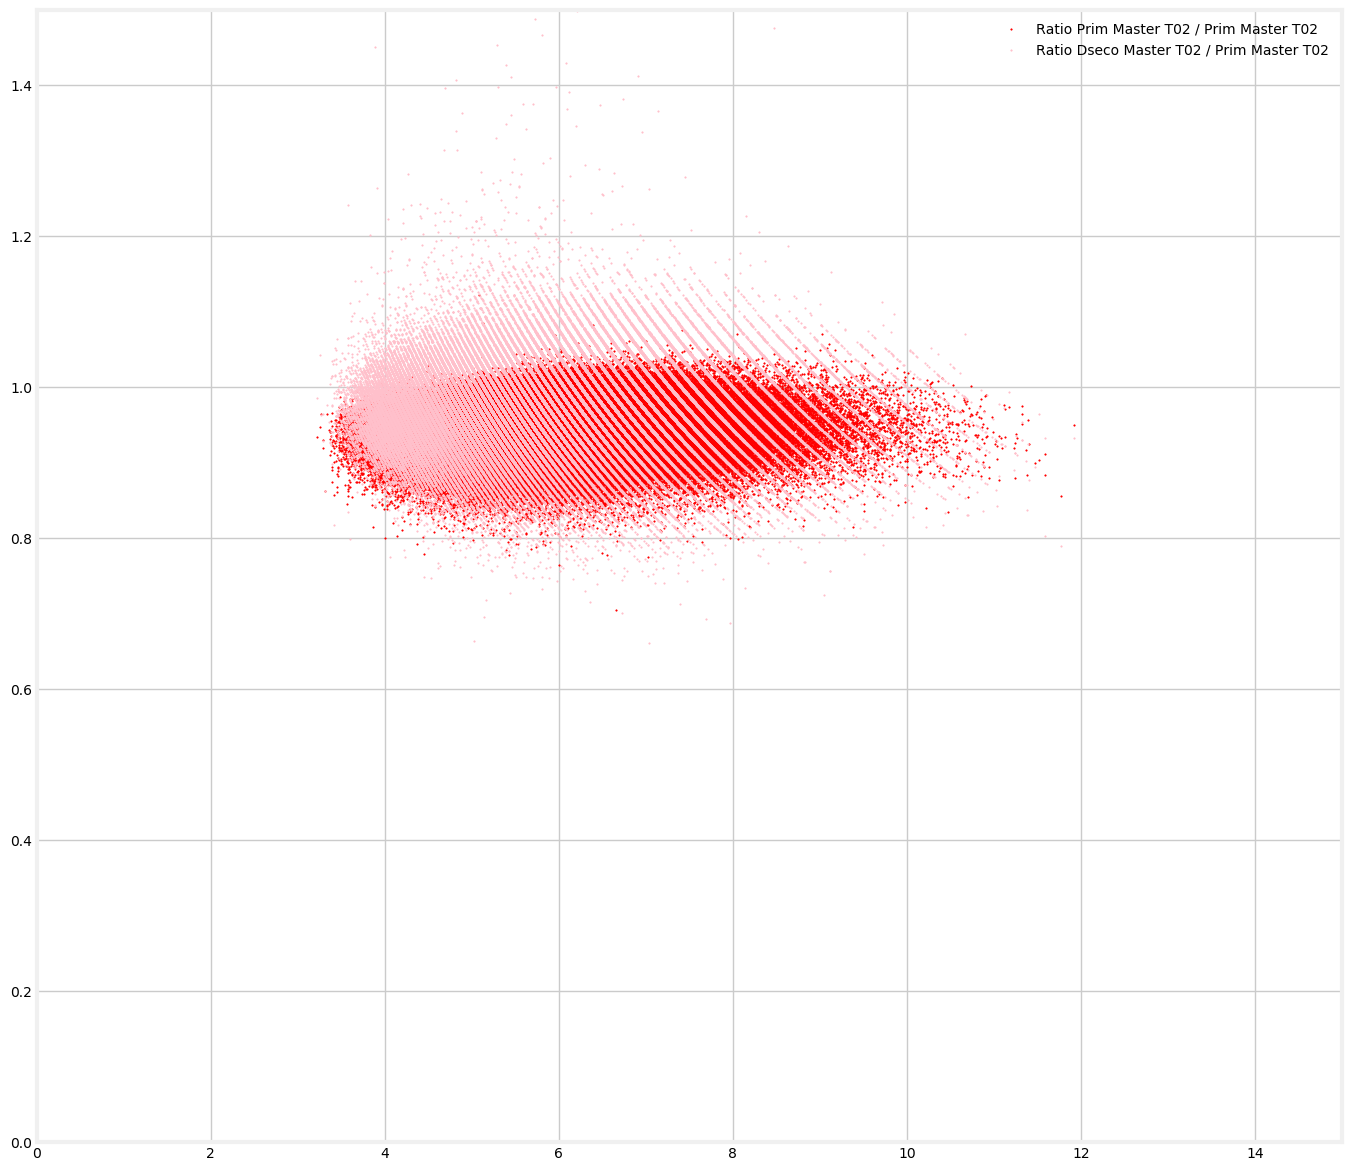

In [104]:
idx = Recs_Master_prim.index.intersection(Recs_Master_dseco.index)
##idx = recs_RTWS_prim.index.intersection(Recs_Master_dseco.index)
plt.figure(figsize=(15,15),dpi=100)
plt.scatter(merged_masters.Tz,merged_masters.T02_x/merged_masters.Tz,s=1,c='r')
plt.scatter(merged_masters.Tz,merged_masters.T02_y/merged_masters.Tz,s=1,c='pink')
plt.xlim(left=0,right=15)
plt.ylim(bottom=0,top=1.5)
plt.legend(['Ratio Prim Master T02 / Prim Master Tz','Ratio Dseco Master T02 / Prim Master Tz'],frameon=False)

In [ ]:
plt.hist(merged_masters.Hsig, bins=14, density=True)

In [21]:
import statsmodels.stats.api as sms

sms.DescrStatsW(merged_masters.Hm0_x).tconfint_mean()

(1.3401719915498997, 1.3437417172830708)

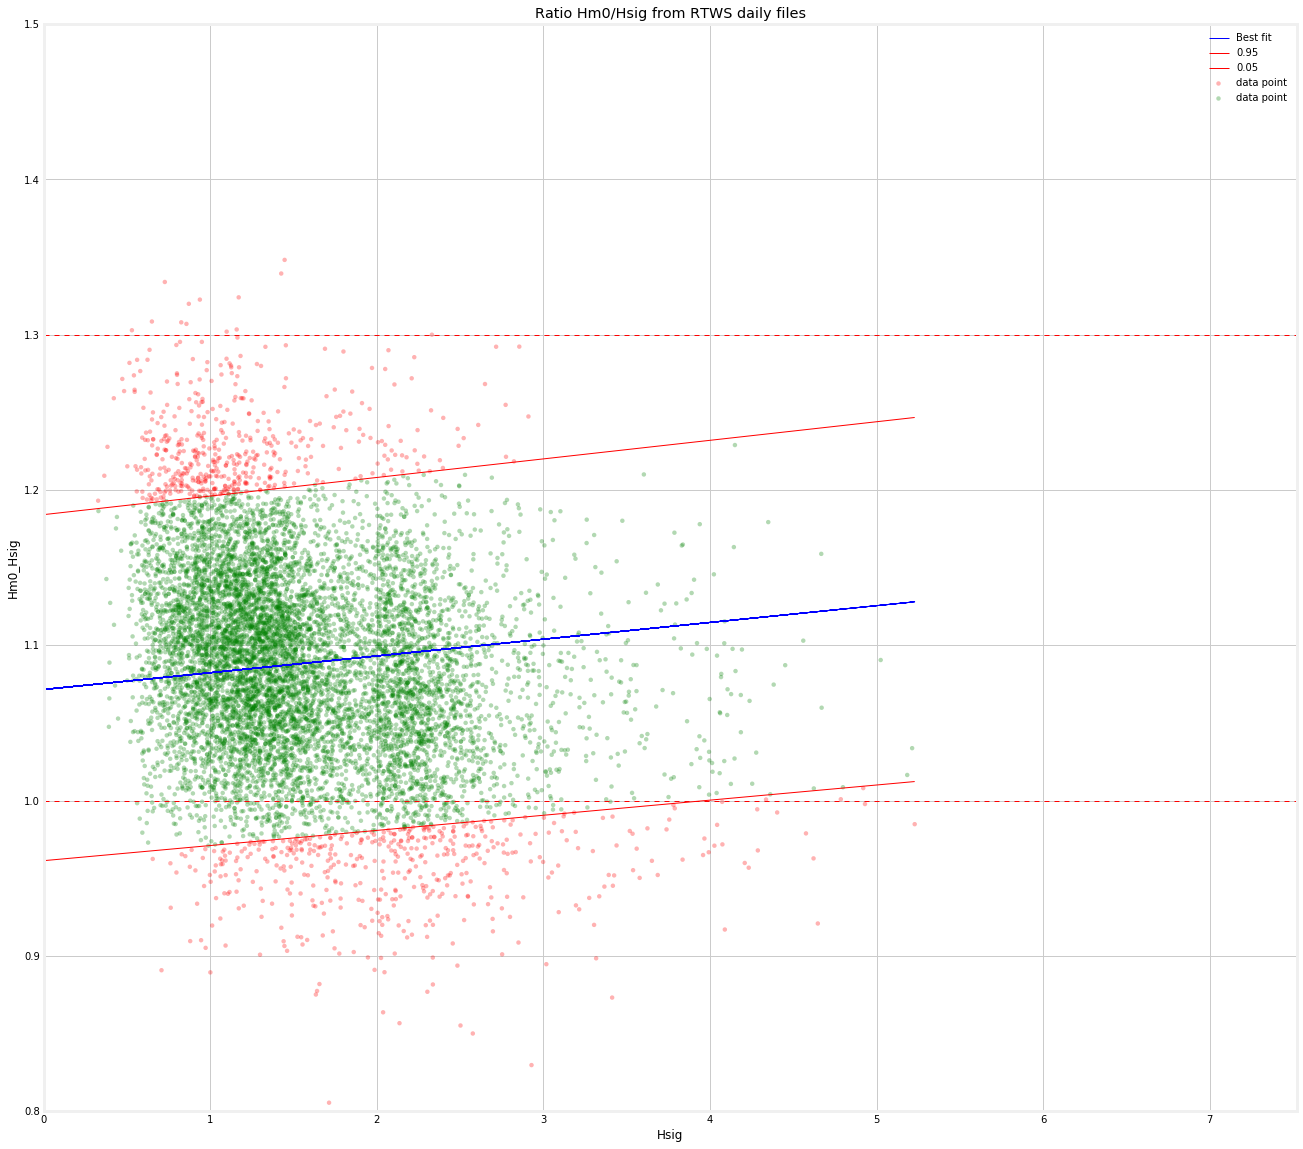

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

df = pd.DataFrame([])
df['Hsig'] = recs_RTWS_prim.Hsig
df['Hm0_Hsig'] = recs_RTWS_prim.Hm0/recs_RTWS_prim.Hsig

model = smf.quantreg('Hm0_Hsig ~ Hsig', df)
quantiles = [0.05, 0.95]
fits = [model.fit(q=q) for q in quantiles]
figure, axes = plt.subplots(figsize=(20,20))
x = df['Hsig']
y = df['Hm0_Hsig']

fit = np.polyfit(x, y, deg=1)
_x = np.linspace(x.min(), x.max(), num=len(y))

# fit lines
_y_005 = fits[0].params['Hsig'] * _x + fits[0].params['Intercept']
_y_095 = fits[1].params['Hsig'] * _x + fits[1].params['Intercept']

# start and end coordinates of fit lines
p = np.column_stack((x, y))
a = np.array([_x[0], _y_005[0]]) #first point of 0.05 quantile fit line
b = np.array([_x[-1], _y_005[-1]]) #last point of 0.05 quantile fit line

a_ = np.array([_x[0], _y_095[0]])
b_ = np.array([_x[-1], _y_095[-1]])

#mask based on if coordinates are above 0.95 or below 0.05 quantile fitlines using cross product
mask = lambda p, a, b, a_, b_: (np.cross(p-a, b-a) > 0) | (np.cross(p-a_, b_-a_) < 0)
mask = mask(p, a, b, a_, b_)

axes.set_title('Ratio Hm0/Hsig from RTWS daily files')

axes.scatter(x[mask], df['Hm0_Hsig'][mask], facecolor='r', edgecolor='none', s=20, alpha=0.3, label='data point')
axes.scatter(x[~mask], df['Hm0_Hsig'][~mask], facecolor='g', edgecolor='none', s=20, alpha=0.3, label='data point')

axes.plot(x, fit[0] * x + fit[1], label='Best fit', lw=1, c='b')
axes.plot(_x, _y_095, label=quantiles[1], lw=1, c='r')
axes.plot(_x, _y_005, label=quantiles[0], lw=1, c='r')

axes.legend(loc=1,frameon=False)
axes.set_xlabel('Hsig')
axes.set_ylabel('Hm0_Hsig')
axes.set_xlim(0,max(Recs_Master_prim.Hsig))
axes.set_ylim(bottom=0.8,top=1.5)

axes.plot([0,max(Recs_Master_prim.Hsig)],[1.3,1.3],lw=1.0,c="r",dashes=[5, 5, 5, 5])
axes.plot([0,max(Recs_Master_prim.Hsig)],[1.0,1.0],lw=1.0,c="r",dashes=[5, 5, 5, 5])

plt.show()

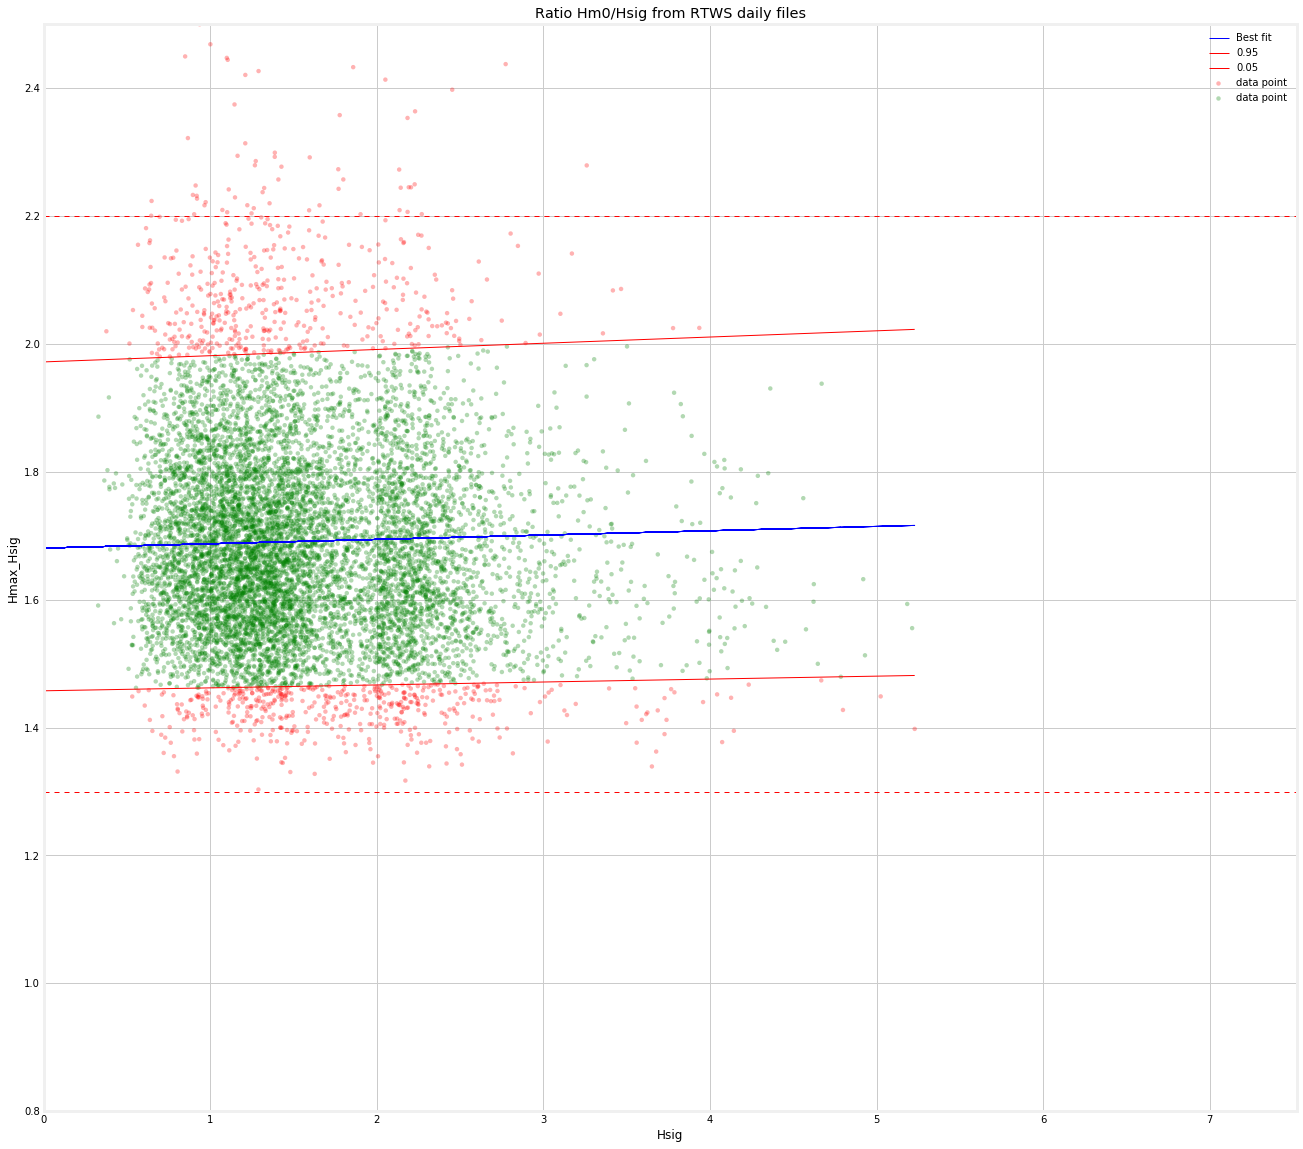

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

df = pd.DataFrame([])
df['Hsig'] = recs_RTWS_prim.Hsig
df['Hmax_Hsig'] = recs_RTWS_prim.Hmax/recs_RTWS_prim.Hsig

model = smf.quantreg('Hmax_Hsig ~ Hsig', df)
quantiles = [0.05, 0.95]
fits = [model.fit(q=q) for q in quantiles]
figure, axes = plt.subplots(figsize=(20,20))
x = df['Hsig']
y = df['Hmax_Hsig']

fit = np.polyfit(x, y, deg=1)
_x = np.linspace(x.min(), x.max(), num=len(y))

# fit lines
_y_005 = fits[0].params['Hsig'] * _x + fits[0].params['Intercept']
_y_095 = fits[1].params['Hsig'] * _x + fits[1].params['Intercept']

# start and end coordinates of fit lines
p = np.column_stack((x, y))
a = np.array([_x[0], _y_005[0]]) #first point of 0.05 quantile fit line
b = np.array([_x[-1], _y_005[-1]]) #last point of 0.05 quantile fit line

a_ = np.array([_x[0], _y_095[0]])
b_ = np.array([_x[-1], _y_095[-1]])

#mask based on if coordinates are above 0.95 or below 0.05 quantile fitlines using cross product
mask = lambda p, a, b, a_, b_: (np.cross(p-a, b-a) > 0) | (np.cross(p-a_, b_-a_) < 0)
mask = mask(p, a, b, a_, b_)

axes.set_title('Ratio Hmax/Hsig from RTWS daily files')

axes.scatter(x[mask], df['Hmax_Hsig'][mask], facecolor='r', edgecolor='none', s=20, alpha=0.3, label='data point')
axes.scatter(x[~mask], df['Hmax_Hsig'][~mask], facecolor='g', edgecolor='none', s=20, alpha=0.3, label='data point')

axes.plot(x, fit[0] * x + fit[1], label='Best fit', lw=1, c='b')
axes.plot(_x, _y_095, label=quantiles[1], lw=1, c='r')
axes.plot(_x, _y_005, label=quantiles[0], lw=1, c='r')

axes.legend(loc=1,frameon=False)
axes.set_xlabel('Hsig')
axes.set_ylabel('Hmax_Hsig')
axes.set_xlim(0,max(Recs_Master_prim.Hsig))
axes.set_ylim(bottom=0.8,top=2.5)

axes.plot([0,max(Recs_Master_prim.Hsig)],[1.3,1.3],lw=1.0,c="r",dashes=[5, 5, 5, 5])
axes.plot([0,max(Recs_Master_prim.Hsig)],[2.2,2.2],lw=1.0,c="r",dashes=[5, 5, 5, 5])

plt.show()

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

df = pd.DataFrame([])
df['Tz'] = recs_RTWS_prim.Tz
df['T02_Tz'] = recs_RTWS_prim.T02/recs_RTWS_prim.Tz

model = smf.quantreg('T02_Tz ~ Tz', df)
quantiles = [0.05, 0.95]
fits = [model.fit(q=q) for q in quantiles]
figure, axes = plt.subplots(figsize=(20,20))
x = df['Tz']
y = df['T02_Tz']

fit = np.polyfit(x, y, deg=1)

_x = np.linspace(x.min(), x.max(), num=len(y))

# fit lines
_y_005 = fits[0].params['Tz'] * _x + fits[0].params['Intercept']
_y_095 = fits[1].params['Tz'] * _x + fits[1].params['Intercept']

# start and end coordinates of fit lines
p = np.column_stack((x, y))
a = np.array([_x[0], _y_005[0]]) #first point of 0.05 quantile fit line
b = np.array([_x[-1], _y_005[-1]]) #last point of 0.05 quantile fit line

a_ = np.array([_x[0], _y_095[0]])
b_ = np.array([_x[-1], _y_095[-1]])

#mask based on if coordinates are above 0.95 or below 0.05 quantile fitlines using cross product
mask = lambda p, a, b, a_, b_: (np.cross(p-a, b-a) > 0) | (np.cross(p-a_, b_-a_) < 0)
mask = mask(p, a, b, a_, b_)

axes.set_title('Ratio T02/Tz from RTWS daily files')

axes.scatter(x[mask], df['T02_Tz'][mask], facecolor='r', edgecolor='none', s=20, alpha=0.3, label='data point')
axes.scatter(x[~mask], df['T02_Tz'][~mask], facecolor='g', edgecolor='none', s=20, alpha=0.3, label='data point')

axes.plot(x, fit[0] * x + fit[1], label='Best fit', lw=1, c='b')
axes.plot(_x, _y_095, label=quantiles[1], lw=1, c='r')
axes.plot(_x, _y_005, label=quantiles[0], lw=1, c='r')

axes.legend(loc=1,frameon=False)
axes.set_xlabel('Tz')
axes.set_ylabel('T02_Tz')
axes.set_xlim(2,max(Recs_Master_prim.Tz))
axes.set_ylim(bottom=0.6,top=1.4)

axes.plot([0,max(Recs_Master_prim.Tz)],[0.8,0.8],lw=1.0,c="r",dashes=[5, 5, 5, 5])
axes.plot([0,max(Recs_Master_prim.Tz)],[1.3,1.3],lw=1.0,c="r",dashes=[5, 5, 5, 5])

plt.show()